In [ ]:
"""
3. Tareas Desglosadas:
Etapa 1: Preparación de Datos

Scraping y obtención de datos:
Usar la API de Riot para extraer datos de partidas clasificatorias de alto nivel.
Limitar los datos al último parche para mantener la relevancia.
Descargar datos adicionales para variables exógenas (clima en competencias, horarios de partidas, etc., si es relevante).
Limpieza y estructura:
Evaluar calidad de los datos: valores nulos, duplicados, inconsistencias.
Normalizar datos relevantes: daño por minuto, oro por minuto, etc.
Etapa 2: Análisis Exploratorio

Crear gráficos y tablas para visualizar:

Frecuencia de campeones, roles y objetos.
Relación entre KDA (Kills/Deaths/Assists) y victorias.
Eficiencia en objetivos (torretas, dragones, etc.) y resultados de partidas.
Realizar segmentaciones:

Por roles (jungla, mid, etc.).
Por regiones si los datos están disponibles.
Etapa 3: Análisis Avanzado

Series de tiempo:

Analizar cambios en la popularidad de campeones/estrategias a lo largo del parche.
Análisis de correlación:

Evaluar qué métricas tienen mayor correlación con la victoria.
Outliers:

Detectar jugadores, campeones o equipos con métricas anómalas (ejemplo: daño altísimo o tasas de victoria extremas).
Análisis de Cohortes:

Crear cohortes basadas en tiempo jugado, composición de equipo, o estrategias comunes.
Etapa 4: Modelado Predictivo

Clasificación:

Crear un modelo para predecir si un equipo ganará o no basado en:
Selección de campeones.
Composición de roles.
Estadísticas acumuladas.
Regresión:

Modelar el impacto de factores como "oro ganado por minuto" en la probabilidad de victoria.
Cumplimiento de Requisitos Mínimos
Scraping: La API de Riot proporcionará datos base.
EDA: Gráficos como histogramas, boxplots y diagramas de dispersión ayudarán a cumplir este punto.
Análisis de calidad: Puedes identificar datos faltantes o duplicados en las partidas.
Segmentación: Dividir datos por roles, regiones o niveles de habilidad.
Modelos predictivos: Usar clasificación y regresión regularizada (ej. Ridge o Lasso).
Análisis de tiempo: Detectar cambios en las tendencias del meta a lo largo del parche.
Correlaciones: Examinar qué métricas afectan más a la victoria.
Cohortes: Segmentar por estrategias o jugadores destacados.
Gráficos: Visualizar variables como daño, roles o victorias.
Outliers: Detectar partidas con resultados extremos para análisis adicional.
Viabilidad en Dos Semanas
Con tres horas al día, este proyecto es ambicioso, pero factible si te organizas bien. Sugiero:

Días 1-4: Obtención de datos y limpieza.
Días 5-7: Análisis exploratorio y gráfico.
Días 8-10: Modelos predictivos y validación.
Días 11-12: Análisis avanzado (cohortes, correlaciones, etc.).
Días 13-14: Refinamiento, documentación, y presentación en GitHub.
Si necesitas más ideas concretas o guía en alguna etapa, dime y profundizamos. ¡Adelante con el proyecto!
"""

In [ ]:
"""
Etapa 1: Preparación de Datos

Scraping y obtención de datos:
Usar la API de Riot para extraer datos de partidas clasificatorias de alto nivel.
Limitar los datos al último parche para mantener la relevancia.
Descargar datos adicionales para variables exógenas (clima en competencias, horarios de partidas, etc., si es relevante).
Limpieza y estructura:
Evaluar calidad de los datos: valores nulos, duplicados, inconsistencias.
Normalizar datos relevantes: daño por minuto, oro por minuto, etc.
"""

In [18]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json
import csv
import time

In [10]:

API_KEY = "RGAPI-dc70cad0-9a75-4fb7-a7f0-7eadd4d9a69e"

In [8]:
from dotenv import load_dotenv
import os

load_dotenv()
API_KEY = os.getenv("RIOT_API_KEY")


In [24]:
import requests
import time

# Configuración inicial
API_KEY = "RGAPI-dc70cad0-9a75-4fb7-a7f0-7eadd4d9a69e"
REGION = 'euw1'  # Cambia según la región deseada (e.g., na1, kr, etc.)
CHALLENGER_URL = f'https://{REGION}.api.riotgames.com/lol/league/v4/challengerleagues/by-queue/RANKED_SOLO_5x5'
SUMMONER_URL = f'https://{REGION}.api.riotgames.com/lol/summoner/v4/summoners/'

HEADERS = {
    'X-Riot-Token': API_KEY
}

# Límites de tasa
RATE_LIMIT_SECOND = 20  # 20 requests por segundo
RATE_LIMIT_WINDOW = 120  # 100 requests por cada 2 minutos
RATE_LIMIT_REQUESTS = 99  # Límite de solicitudes por ventana

def get_challenger_players():
    """
    Obtiene la lista de jugadores en Challenger junto con sus summonerIds.
    """
    response = requests.get(CHALLENGER_URL, headers=HEADERS)
    if response.status_code == 200:
        challenger_data = response.json()
        return challenger_data['entries']  # Lista de LeagueItemDTO
    else:
        print(f"Error al obtener la lista de Challengers: {response.status_code}")
        return []

def get_puuid(summoner_id):
    """
    Obtiene el PUUID de un jugador a partir de su summonerId.
    """
    response = requests.get(SUMMONER_URL + summoner_id, headers=HEADERS)
    if response.status_code == 200:
        summoner_data = response.json()
        return summoner_data['puuid']
    else:
        print(f"Error al obtener PUUID para el summonerId {summoner_id}: {response.status_code}")
        return None

def rate_limited_request(requests_count, start_time):
    """
    Controla el límite de tasa para evitar exceder los límites de la API.
    """
    elapsed_time = time.time() - start_time

    # Pausar si excedemos los límites por segundo
    if requests_count % RATE_LIMIT_SECOND == 0:
        time.sleep(1)

    # Pausar si excedemos los límites de 2 minutos
    if requests_count >= RATE_LIMIT_REQUESTS and elapsed_time < RATE_LIMIT_WINDOW:
        sleep_time = RATE_LIMIT_WINDOW - elapsed_time
        print(f"Esperando {sleep_time:.2f} segundos para evitar exceder el límite de 100 solicitudes en 2 minutos...")
        time.sleep(sleep_time)
        return 0, time.time()  # Reiniciar contador y tiempo de inicio
    return requests_count, start_time

def main():
    """
    Obtiene la lista completa de PUUIDs para jugadores Challenger.
    """
    # Obtener jugadores Challenger
    challengers = get_challenger_players()
    print(f"Se encontraron {len(challengers)} jugadores en Challenger.")

    # Extraer PUUIDs
    puuids = []
    requests_count = 0
    start_time = time.time()

    for player in challengers:
        summoner_id = player['summonerId']

        # Control de límite de tasa
        requests_count, start_time = rate_limited_request(requests_count, start_time)

        # Obtener el PUUID
        puuid = get_puuid(summoner_id)
        requests_count += 1  # Incrementar contador de solicitudes
        if puuid:
            puuids.append(puuid)

    print(f"Se obtuvieron {len(puuids)} PUUIDs.")
    return puuids

if __name__ == "__main__":
    puuids = main()


Se encontraron 300 jugadores en Challenger.
Esperando 97.56 segundos para evitar exceder el límite de 100 solicitudes en 2 minutos...
Esperando 98.77 segundos para evitar exceder el límite de 100 solicitudes en 2 minutos...
Esperando 98.37 segundos para evitar exceder el límite de 100 solicitudes en 2 minutos...
Se obtuvieron 300 PUUIDs.


In [26]:
import requests
import time

# Configuración inicial
API_KEY = "RGAPI-dc70cad0-9a75-4fb7-a7f0-7eadd4d9a69e"
REGION = 'europe'  # Para datos de partidas usa la región de clúster, no "euw1"
MATCH_URL = f'https://{REGION}.api.riotgames.com/lol/match/v5/matches/by-puuid/'
MATCH_DETAILS_URL = f'https://{REGION}.api.riotgames.com/lol/match/v5/matches/'

HEADERS = {
    'X-Riot-Token': API_KEY
}

# Límites de tasa
RATE_LIMIT_SECOND = 20  # 20 requests por segundo
RATE_LIMIT_WINDOW = 120  # 100 requests por cada 2 minutos
RATE_LIMIT_REQUESTS = 99  # Límite de solicitudes por ventana

def get_matches(puuid, start=0, count=20):
    """
    Obtiene una lista de IDs de partidas para un jugador dado su PUUID.
    """
    url = f"{MATCH_URL}{puuid}/ids?start={start}&count={count}"
    response = requests.get(url, headers=HEADERS)
    if response.status_code == 200:
        return response.json()  # Lista de IDs de partidas
    else:
        print(f"Error al obtener partidas para el PUUID {puuid}: {response.status_code}")
        return []

def get_match_details(match_id):
    """
    Obtiene los detalles de una partida dado su ID.
    """
    url = f"{MATCH_DETAILS_URL}{match_id}"
    response = requests.get(url, headers=HEADERS)
    if response.status_code == 200:
        return response.json()  # Detalles de la partida
    else:
        print(f"Error al obtener detalles para la partida {match_id}: {response.status_code}")
        return None

def rate_limited_request(requests_count, start_time):
    """
    Controla el límite de tasa para evitar exceder los límites de la API.
    """
    elapsed_time = time.time() - start_time

    # Pausar si excedemos los límites por segundo
    if requests_count % RATE_LIMIT_SECOND == 0:
        time.sleep(1)

    # Pausar si excedemos los límites de 2 minutos
    if requests_count >= RATE_LIMIT_REQUESTS and elapsed_time < RATE_LIMIT_WINDOW:
        sleep_time = RATE_LIMIT_WINDOW - elapsed_time
        print(f"Esperando {sleep_time:.2f} segundos para evitar exceder el límite de 100 solicitudes en 2 minutos...")
        time.sleep(sleep_time)
        return 0, time.time()  # Reiniciar contador y tiempo de inicio
    return requests_count, start_time

def extract_match_data(puuids, matches_per_player=20):
    """
    Extrae datos de partidas para una lista de PUUIDs.
    """
    all_match_details = []
    requests_count = 0
    start_time = time.time()

    for puuid in puuids:
        print(f"Obteniendo partidas para PUUID: {puuid}")

        # Control de límite de tasa
        requests_count, start_time = rate_limited_request(requests_count, start_time)

        # Obtener IDs de partidas
        match_ids = get_matches(puuid, count=matches_per_player)
        requests_count += 1

        for match_id in match_ids:
            # Control de límite de tasa
            requests_count, start_time = rate_limited_request(requests_count, start_time)

            # Obtener detalles de la partida
            match_details = get_match_details(match_id)
            requests_count += 1

            if match_details:
                all_match_details.append(match_details)

    print(f"Se extrajeron datos de {len(all_match_details)} partidas.")
    return all_match_details

if __name__ == "__main__":
    # Lista de PUUIDs (puedes cargar esta lista desde tu script anterior)
    matches_per_player = 20  # Número de partidas a extraer por jugador

    match_data = extract_match_data(puuids, matches_per_player=matches_per_player)


Obteniendo partidas para PUUID: 7ZXWAxbs8CU9FpBVG1UoLHvz6kNnHL3Hx9gwOdTJMfCNYCzNuGN22N-xrttDBVd_mqJNB-bZVM8szA
Obteniendo partidas para PUUID: yk7T5tHHBskBTVopeBGE2knEHdD04R3wSXrG1tiZJOJR3no7C9FcLsNeXRmIYjOQ0ZuWoUb4M9t5zQ
Obteniendo partidas para PUUID: Hn1kCHmipABaT6oDy7O87UMBjWVQWFpTVVT4LhN6z83zi2Qx7mvhbaL73ARPygO5blLuT0PJ18tyLw
Obteniendo partidas para PUUID: 32jh9CFQ8yGXW9TOn-wVkvQbnEmg4lceIhSN0qNHf5P_ZlcLTvtY6_jWm-WcgnOapOpHRAiNpWbbSg
Obteniendo partidas para PUUID: 8oQ-fL7s3rQC1Edp2tbzlfifM3g5SDMkiEEIBbGysZI7ehGygdPjT6NmRkSYaUJhsqnDYLnIw1FC8Q
Esperando 92.61 segundos para evitar exceder el límite de 100 solicitudes en 2 minutos...
Error al obtener detalles para la partida EUW1_7207502250: 429
Error al obtener detalles para la partida EUW1_7207458171: 429
Error al obtener detalles para la partida EUW1_7207363268: 429
Obteniendo partidas para PUUID: zBU_ZrHhUroutqjR_SqrmKPlgzuOmDb8WdJKI9-Gracu6T2WBdOrmDklu1QY1_YN1UvykuUNZ8B0Jg
Obteniendo partidas para PUUID: UlCpwk3B_GKq8-cNaklslsj

In [204]:
import pandas as pd

def save_full_match_data_to_csv(match_data, filename="full_match_data.csv"):
    """
    Guarda todos los datos de las partidas en un archivo CSV.
    
    :param match_data: Lista de detalles completos de las partidas.
    :param filename: Nombre del archivo CSV de salida.
    """
    # Lista para almacenar los datos a guardar
    match_rows = []
    
    for match in match_data:
        # Extraer metadatos de la partida
        match_id = match.get("metadata", {}).get("matchId", "")
        data_version = match.get("metadata", {}).get("dataVersion", "")
        participants = match.get("metadata", {}).get("participants", [])
        
        # Extraer info de la partida
        game_creation = match.get("info", {}).get("gameCreation", "")
        game_duration = match.get("info", {}).get("gameDuration", "")
        game_end_timestamp = match.get("info", {}).get("gameEndTimestamp", "")
        game_start_timestamp = match.get("info", {}).get("gameStartTimestamp", "")
        game_mode = match.get("info", {}).get("gameMode", "")
        game_name = match.get("info", {}).get("gameName", "")
        game_type = match.get("info", {}).get("gameType", "")
        game_version = match.get("info", {}).get("gameVersion", "")
        map_id = match.get("info", {}).get("mapId", "")
        platform_id = match.get("info", {}).get("platformId", "")
        queue_id = match.get("info", {}).get("queueId", "")
        tournament_code = match.get("info", {}).get("tournamentCode", "")
        
        # Extraer equipos
        teams = match.get("info", {}).get("teams", [])
        
        # Iterar sobre cada participante en la partida
        for participant in match.get("info", {}).get("participants", []):
            # Extraer los datos del participante
            match_rows.append({
                "match_id": match_id,
                "data_version": data_version,
                "participants": participants,
                "game_creation": game_creation,
                "game_duration": game_duration,
                "game_end_timestamp": game_end_timestamp,
                "game_start_timestamp": game_start_timestamp,
                "game_mode": game_mode,
                #"game_name": game_name,
                #"game_type": game_type,
                "game_version": game_version,
                #"map_id": map_id,
                #"platform_id": platform_id,
                #"queue_id": queue_id,
                #"tournament_code": tournament_code,
                "team_id": participant.get("teamId", ""),
                "summoner_name": participant.get("summonerName", ""),
                "champion_name": participant.get("championName", ""),
                "champion_id": participant.get("championId", ""),
                "kills": participant.get("kills", 0),
                "deaths": participant.get("deaths", 0),
                "assists": participant.get("assists", 0),
                "total_damage_dealt": participant.get("totalDamageDealt", 0),
                "gold_earned": participant.get("goldEarned", 0),
                "win": participant.get("win", False),
                "lane": participant.get("lane", ""),
                "role": participant.get("role", ""),
                "vision_score": participant.get("visionScore", 0),
                #"wards_placed": participant.get("wardsPlaced", 0),
                #"wards_killed": participant.get("wardsKilled", 0),
                #"total_heals_on_teammates": participant.get("totalHealsOnTeammates", 0),
                "total_minions_killed": participant.get("totalMinionsKilled", 0),
                "total_damage_taken": participant.get("totalDamageTaken", 0),
                "time_played": participant.get("timePlayed", 0),
                #"total_ally_jungle_minions_killed": participant.get("totalAllyJungleMinionsKilled", 0),
                "total_damage_dealt_to_champions": participant.get("totalDamageDealtToChampions", 0),
                "total_heal": participant.get("totalHeal", 0),
                #"total_damage_shielded_on_teammates": participant.get("totalDamageShieldedOnTeammates", 0),
                #"total_enemy_jungle_minions_killed": participant.get("totalEnemyJungleMinionsKilled", 0),
                "time_ccing_others": participant.get("timeCCingOthers", 0),
                #"total_units_healed": participant.get("totalUnitsHealed", 0),
                "total_kills": participant.get("kills", 0),
                "penta_kills": participant.get("pentaKills", 0),
                "quadra_kills": participant.get("quadraKills", 0),
                "triple_kills": participant.get("tripleKills", 0),
                "double_kills": participant.get("doubleKills", 0),
                "first_blood_kill": participant.get("firstBloodKill", False),
                #"first_blood_assist": participant.get("firstBloodAssist", False),
                "first_tower_kill": participant.get("firstTowerKill", False),
                #"first_tower_assist": participant.get("firstTowerAssist", False),
                "dragon_kills": participant.get("dragonKills", 0),
                "baron_kills": participant.get("baronKills", 0),
                "inhibitor_kills": participant.get("inhibitorKills", 0),
                "turret_kills": participant.get("turretKills", 0),
                "towers_lost": participant.get("turretsLost", 0),
                #"nexus_kills": participant.get("nexusKills", 0),
                #"nexus_takedowns": participant.get("nexusTakedowns", 0),
                #"total_vision_cleared_pings": participant.get("visionClearedPings", 0),
                "summoner_id": participant.get("summonerId", ""),
                #"summoner_level": participant.get("summonerLevel", 0),
                "summoner_name": participant.get("summonerName", ""),
                #"profile_icon": participant.get("profileIcon", 0),
                #"champ_experience": participant.get("champExperience", 0),
                "champ_level": participant.get("champLevel", 0),
                "role": participant.get("role", ""),
                "individual_position": participant.get("individualPosition", ""),
                "team_position": participant.get("teamPosition", ""),
                #"player_augment_1": participant.get("playerAugment1", 0),
                #"player_augment_2": participant.get("playerAugment2", 0),
                #"player_augment_3": participant.get("playerAugment3", 0),
                #"player_augment_4": participant.get("playerAugment4", 0),
                #"mission": participant.get("missions", {}),
                #"perks": participant.get("perks", {}),
                #"total_damage_to_buildings": participant.get("damageDealtToBuildings", 0),
                "total_damage_to_objectives": participant.get("damageDealtToObjectives", 0),
                #"damage_self_mitigated": participant.get("damageSelfMitigated", 0),
                #"enemy_missing_pings": participant.get("enemyMissingPings", 0),
                #"enemy_vision_pings": participant.get("enemyVisionPings", 0),
                "gold_spent": participant.get("goldSpent", 0),
                #"hold_pings": participant.get("holdPings", 0),
                #"get_back_pings": participant.get("getBackPings", 0),
                #"total_units_healed": participant.get("totalUnitsHealed", 0),
                #"longest_time_spent_living": participant.get("longestTimeSpentLiving", 0),
                #"magic_damage_dealt": participant.get("magicDamageDealt", 0),
                #"magic_damage_dealt_to_champions": participant.get("magicDamageDealtToChampions", 0),
                #"magic_damage_taken": participant.get("magicDamageTaken", 0),
                #"physical_damage_dealt": participant.get("physicalDamageDealt", 0),
                #"physical_damage_dealt_to_champions": participant.get("physicalDamageDealtToChampions", 0),
                #"physical_damage_taken": participant.get("physicalDamageTaken", 0),
                #"true_damage_dealt": participant.get("trueDamageDealt", 0),
                #"true_damage_dealt_to_champions": participant.get("trueDamageDealtToChampions", 0),
                #"true_damage_taken": participant.get("trueDamageTaken", 0),
                #"time_spent_dead": participant.get("totalTimeSpentDead", 0),
                "total_time_cc_dealt": participant.get("totalTimeCCDealt", 0),
                #"vision_wards_bought_in_game": participant.get("visionWardsBoughtInGame", 0),
            })
    
    # Crear un DataFrame con los datos
    df = pd.DataFrame(match_rows)
    df_filtered = df[df['game_version'].str.startswith('14.23')]
    # Guardar el DataFrame en un archivo CSV
    df_filtered.to_csv(filename, index=False)
    print(f"Datos guardados en el archivo {filename}")
    df_filtered.info()

In [206]:
# Llamar a la función de guardado
save_full_match_data_to_csv(match_data, filename="filtered_match_data_14.23.csv")


Datos guardados en el archivo filtered_match_data_14.23.csv
<class 'pandas.core.frame.DataFrame'>
Index: 54980 entries, 0 to 59359
Data columns (total 47 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   match_id                         54980 non-null  object
 1   data_version                     54980 non-null  object
 2   participants                     54980 non-null  object
 3   game_creation                    54980 non-null  int64 
 4   game_duration                    54980 non-null  int64 
 5   game_end_timestamp               54980 non-null  int64 
 6   game_start_timestamp             54980 non-null  int64 
 7   game_mode                        54980 non-null  object
 8   game_version                     54980 non-null  object
 9   team_id                          54980 non-null  int64 
 10  summoner_name                    54980 non-null  object
 11  champion_name                    54980

In [214]:
df = pd.read_csv("filtered_match_data_14.23.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54980 entries, 0 to 54979
Data columns (total 47 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   match_id                         54980 non-null  object
 1   data_version                     54980 non-null  int64 
 2   participants                     54980 non-null  object
 3   game_creation                    54980 non-null  int64 
 4   game_duration                    54980 non-null  int64 
 5   game_end_timestamp               54980 non-null  int64 
 6   game_start_timestamp             54980 non-null  int64 
 7   game_mode                        54980 non-null  object
 8   game_version                     54980 non-null  object
 9   team_id                          54980 non-null  int64 
 10  summoner_name                    51372 non-null  object
 11  champion_name                    54980 non-null  object
 12  champion_id                     

In [216]:
# Mostrar la distribución de 'game_version'
distribution = df['game_version'].value_counts()

# Mostrar la distribución
print(distribution)


game_version
14.23.636.9832    54020
14.23.635.9815      960
Name: count, dtype: int64


In [222]:
import pandas as pd

# Cargar el CSV en un DataFrame
df = pd.read_csv("filtered_match_data_14.23.csv", low_memory=False)

"""deprecated, ya está directamente en el csv solo el último parche
# Filtrar solo partidas clasificatorias (asegurándonos de que 'gameMode' sea "CLASSIC")
df_classificatorias = df[df['game_mode'] == 'CLASSIC']

# Obtener el último parche disponible
ultimo_parche = df_classificatorias['game_version'].max()

# Filtrar solo las partidas del último parche
df_ultimo_parche = df_classificatorias[df_classificatorias['game_version'] == ultimo_parche]
"""


          match_id  data_version  \
0  EUW1_7210922343             2   
1  EUW1_7210922343             2   
2  EUW1_7210922343             2   
3  EUW1_7210922343             2   
4  EUW1_7210922343             2   

                                        participants  game_creation  \
0  ['MmEwQUECKGab-xQkpr7qLaz0ynnFxiFuy6ecsWZ1bMiJ...  1733087598057   
1  ['MmEwQUECKGab-xQkpr7qLaz0ynnFxiFuy6ecsWZ1bMiJ...  1733087598057   
2  ['MmEwQUECKGab-xQkpr7qLaz0ynnFxiFuy6ecsWZ1bMiJ...  1733087598057   
3  ['MmEwQUECKGab-xQkpr7qLaz0ynnFxiFuy6ecsWZ1bMiJ...  1733087598057   
4  ['MmEwQUECKGab-xQkpr7qLaz0ynnFxiFuy6ecsWZ1bMiJ...  1733087598057   

   game_duration  game_end_timestamp  game_start_timestamp game_mode  \
0           1997       1733089637632         1733087639902   CLASSIC   
1           1997       1733089637632         1733087639902   CLASSIC   
2           1997       1733089637632         1733087639902   CLASSIC   
3           1997       1733089637632         1733087639902   CLASSIC

In [226]:
df_ultimo_parche = df.copy()
# Ver las primeras filas del DataFrame filtrado
print(df_ultimo_parche.head())

          match_id  data_version  \
0  EUW1_7210922343             2   
1  EUW1_7210922343             2   
2  EUW1_7210922343             2   
3  EUW1_7210922343             2   
4  EUW1_7210922343             2   

                                        participants  game_creation  \
0  ['MmEwQUECKGab-xQkpr7qLaz0ynnFxiFuy6ecsWZ1bMiJ...  1733087598057   
1  ['MmEwQUECKGab-xQkpr7qLaz0ynnFxiFuy6ecsWZ1bMiJ...  1733087598057   
2  ['MmEwQUECKGab-xQkpr7qLaz0ynnFxiFuy6ecsWZ1bMiJ...  1733087598057   
3  ['MmEwQUECKGab-xQkpr7qLaz0ynnFxiFuy6ecsWZ1bMiJ...  1733087598057   
4  ['MmEwQUECKGab-xQkpr7qLaz0ynnFxiFuy6ecsWZ1bMiJ...  1733087598057   

   game_duration  game_end_timestamp  game_start_timestamp game_mode  \
0           1997       1733089637632         1733087639902   CLASSIC   
1           1997       1733089637632         1733087639902   CLASSIC   
2           1997       1733089637632         1733087639902   CLASSIC   
3           1997       1733089637632         1733087639902   CLASSIC

1. Definir los objetivos específicos
Antes de comenzar con el análisis, asegúrate de tener claros los objetivos que quieres lograr. Como el análisis debe guiar al coach del equipo en la estrategia, algunas áreas clave que podrían ser relevantes son:

Meta actual del juego:

*¿Qué campeones están ganando más partidas? ¿Qué campeones están en las mejores posiciones de win rate en las partidas clasificatorias?

*Posicionamiento de campeones: ¿Cuáles son los campeones más fuertes en cada rol (Top, Jungle, Mid, ADC, Support)?

*Tendencias de objetos: ¿Qué objetos están siendo más efectivos para ciertos campeones o roles?

*Impacto de los dragones, torres, y objetivos mayores: ¿Qué impacto tienen en el resultado final de las partidas las tomas de dragón, torres y barones?

*Composición de equipos: ¿Qué combinaciones de campeones son más exitosas en determinadas composiciones de equipo?


Análisis exploratorio de los datos (EDA)
El análisis exploratorio es clave para entender las características de las partidas y establecer patrones. Algunos análisis que puedes hacer son:

Distribución de los roles y campeones: Analiza qué campeones y roles predominan en las partidas de alto nivel. Esto podría ayudarte a identificar los "pick" más comunes en el meta actual.

Estudio de las estadísticas individuales de los jugadores:

KDA (Killer/Death/Assist): Este es un buen indicador para medir el rendimiento de los jugadores en las partidas.
Gold Earned y Items Comprados: Ver cómo los diferentes objetos se correlacionan con el desempeño del jugador.

C:\Users\chris\AppData\Local\Temp\ipykernel_24088\2154288337.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=champion_counts.index, y=champion_counts.values, palette='viridis')


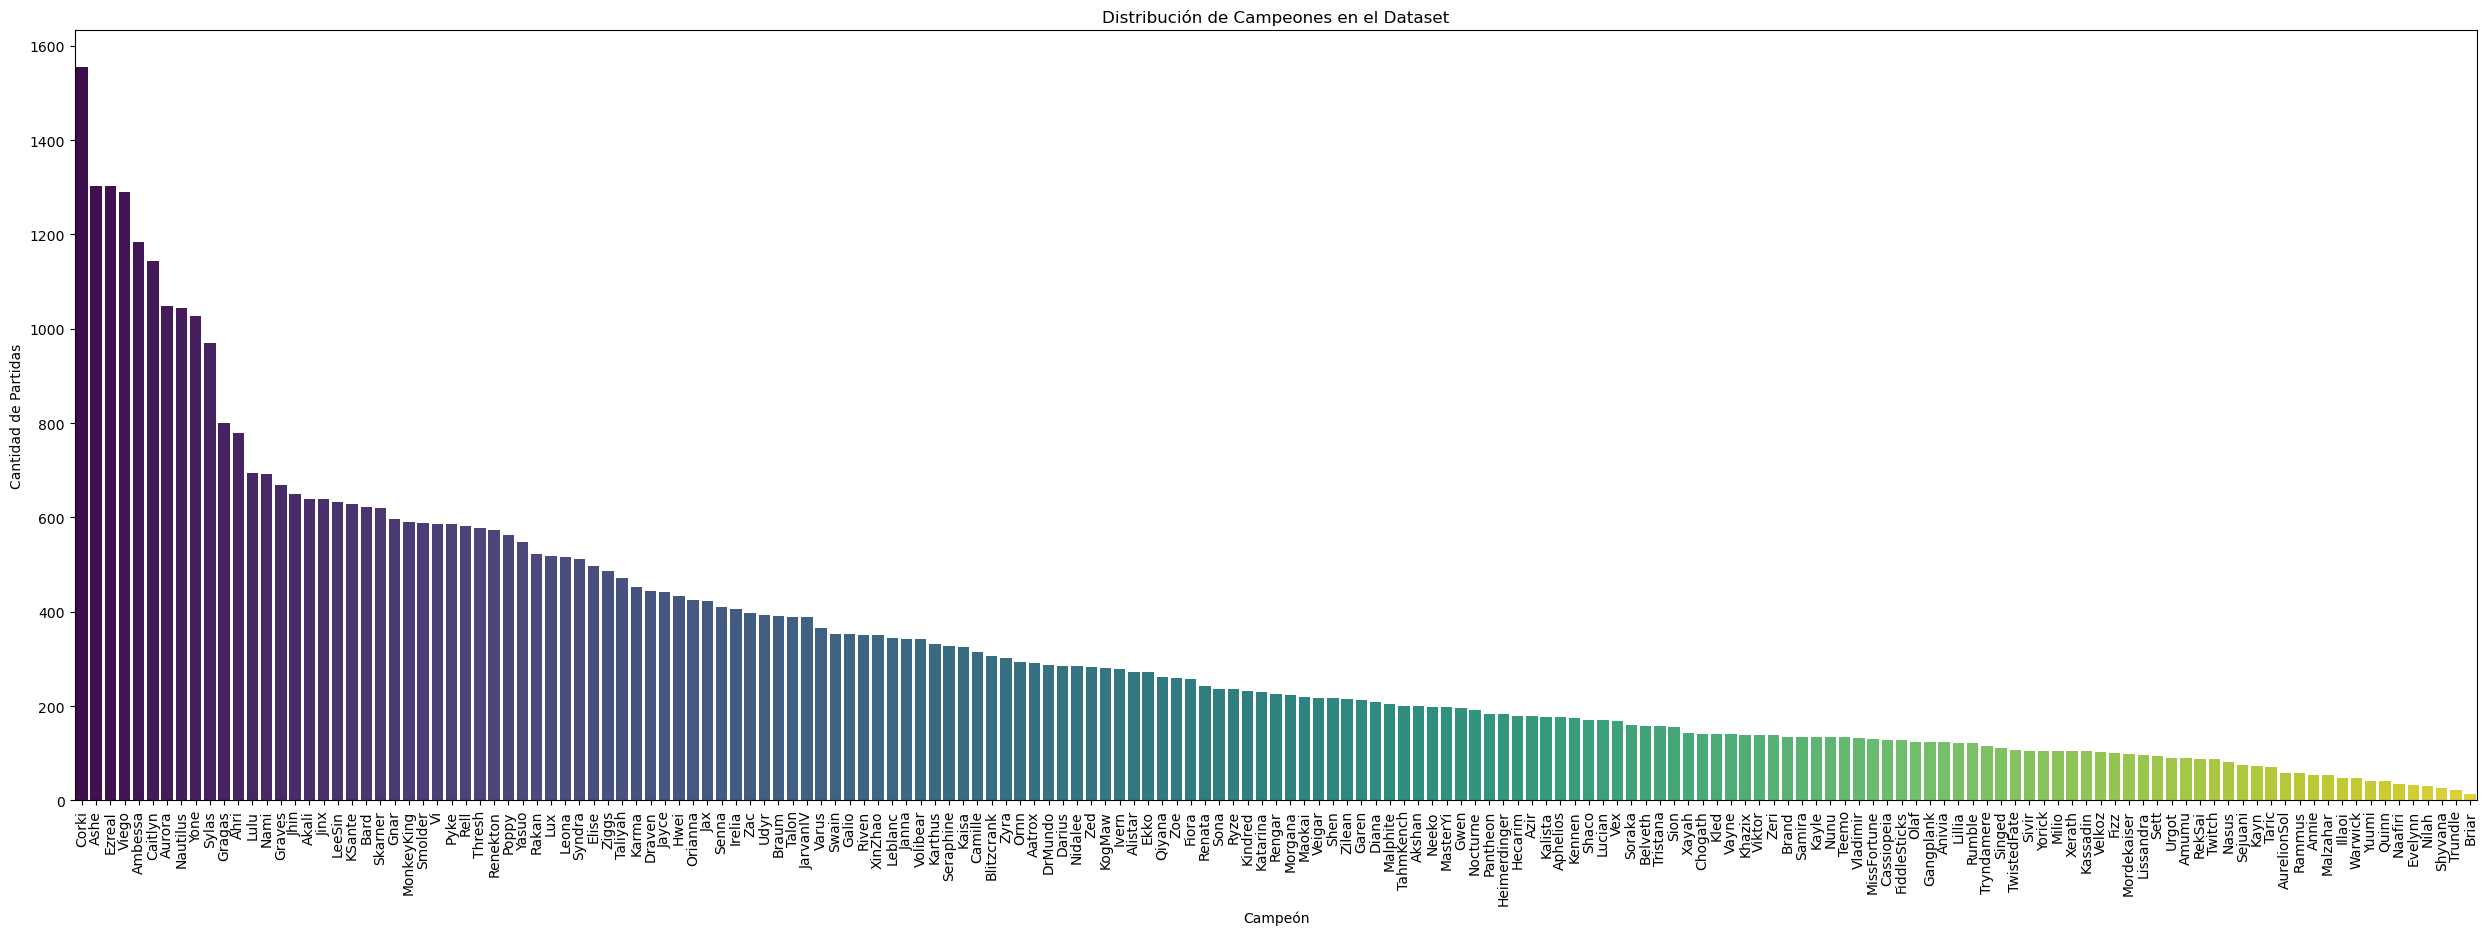

In [228]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribución de los campeones
champion_counts = df_ultimo_parche['champion_name'].value_counts()

# Graficar la distribución de campeones
plt.figure(figsize=(31, 10))
sns.barplot(x=champion_counts.index, y=champion_counts.values, palette='viridis')
plt.xticks(rotation=90)  # Para girar los nombres de los campeones si son largos
plt.xlabel('Campeón')
plt.ylabel('Cantidad de Partidas')
plt.title('Distribución de Campeones en el Dataset')
plt.show()


C:\Users\chris\AppData\Local\Temp\ipykernel_24088\3109230639.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=role_counts.index, y=role_counts.values, palette='Set2')


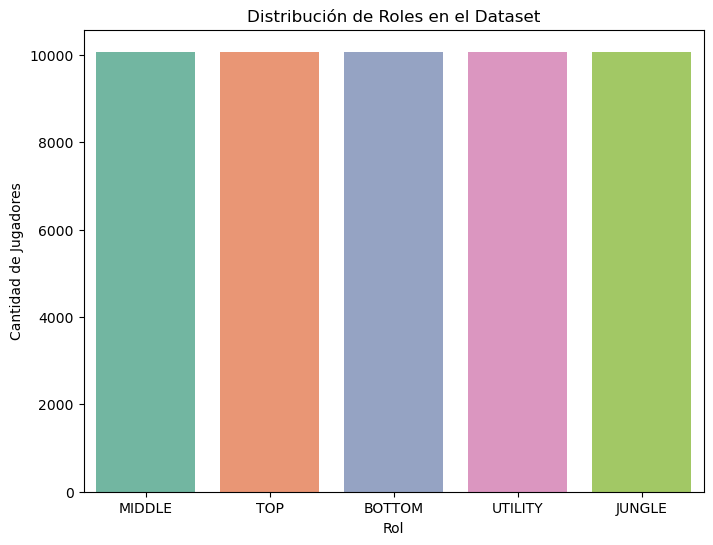

In [96]:
# Distribución de roles 
role_counts = df_ultimo_parche['team_position'].value_counts()

# Graficar la distribución de roles
plt.figure(figsize=(8, 6))
sns.barplot(x=role_counts.index, y=role_counts.values, palette='Set2')
plt.xlabel('Rol')
plt.ylabel('Cantidad de Jugadores')
plt.title('Distribución de Roles en el Dataset')
plt.show()


In [122]:
#Vemos que UTILITY es support y que los datos están correctamente estructurados ya que por partida tiene que haber 1 de cada rol

# Cambiar "UTILITY" a "SUPPORT" en la columna 'team_position'
df_ultimo_parche['team_position'] = df_ultimo_parche['team_position'].replace('UTILITY', 'SUPPORT')

# Verificar los cambios
print(df_ultimo_parche['team_position'].value_counts())


team_position
MIDDLE     10068
TOP        10067
BOTTOM     10067
SUPPORT    10067
JUNGLE     10064
Name: count, dtype: int64


C:\Users\chris\AppData\Local\Temp\ipykernel_24088\1893805062.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['team_position'] = df_ultimo_parche['team_position'].replace('UTILITY', 'SUPPORT')


In [124]:
# Agrupar por campeón y rol
champion_role_counts = df_ultimo_parche.groupby(['champion_name', 'team_position']).size().reset_index(name='count')

# Ver las primeras filas
champion_role_counts.head()


,champion_name,team_position,count
0,Aatrox,MIDDLE,4
1,Aatrox,SUPPORT,1
2,Aatrox,TOP,261
3,Ahri,MIDDLE,736
4,Ahri,SUPPORT,1


<Figure size 6500x2000 with 0 Axes>

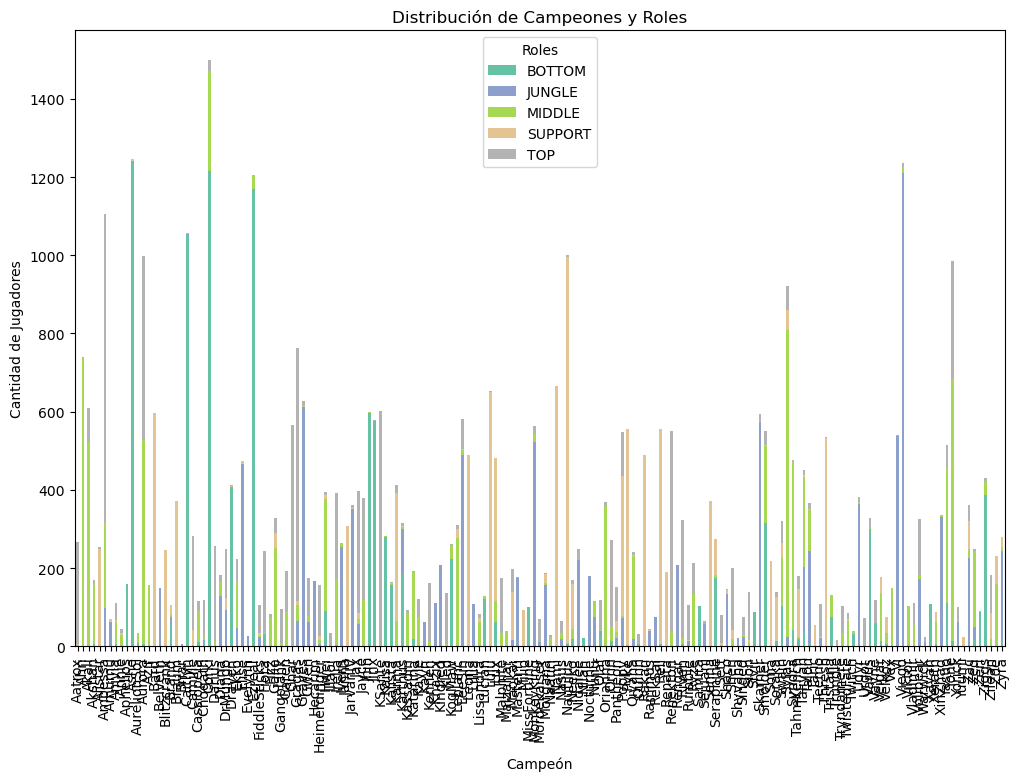

In [132]:
# Pivotar la tabla para que los campeones sean las filas, los roles sean las columnas
champion_role_pivot = champion_role_counts.pivot(index='champion_name', columns='team_position', values='count').fillna(0)

# Graficar la distribución de campeones por rol
plt.figure(figsize=(65, 20))
champion_role_pivot.plot(kind='bar', stacked=True, colormap='Set2', figsize=(12, 8))
plt.title('Distribución de Campeones y Roles')
plt.xlabel('Campeón')
plt.ylabel('Cantidad de Jugadores')
plt.xticks(rotation=90)
plt.legend(title='Roles')
plt.show()


C:\Users\chris\AppData\Local\Temp\ipykernel_24088\1273003964.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='proportion', y='champion_name', data=data, palette='viridis')


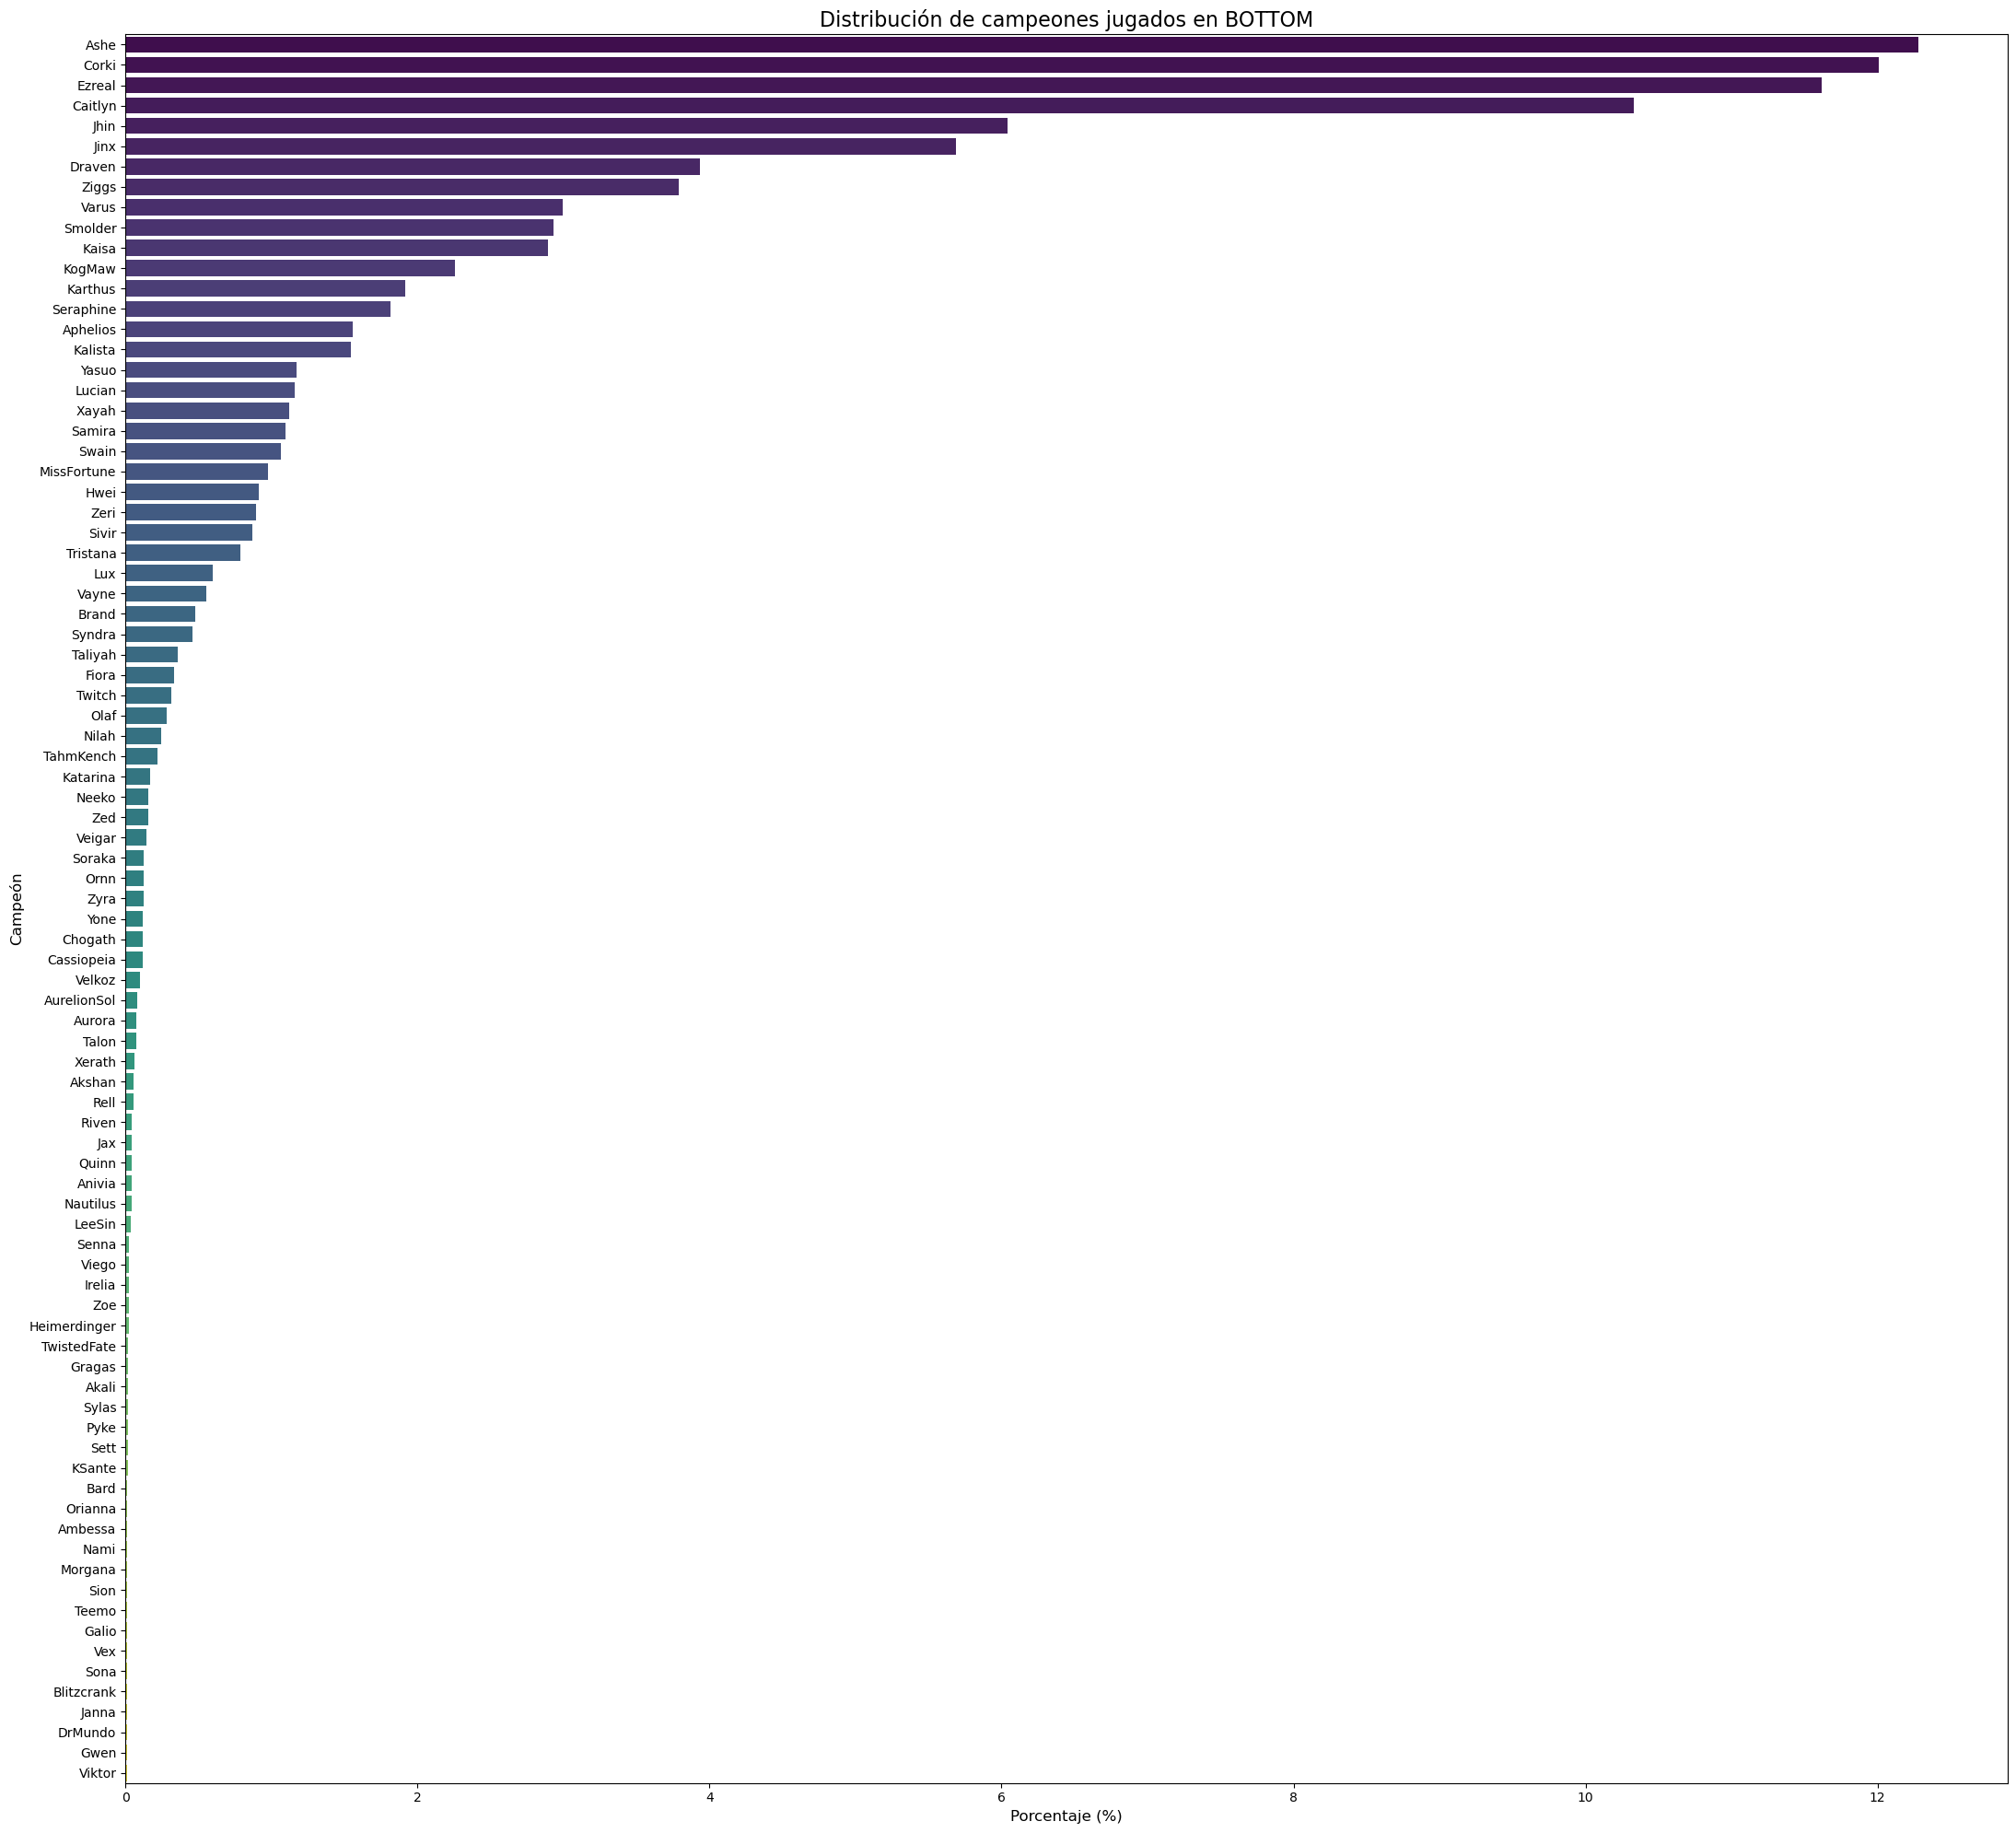

C:\Users\chris\AppData\Local\Temp\ipykernel_24088\1273003964.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='proportion', y='champion_name', data=data, palette='viridis')


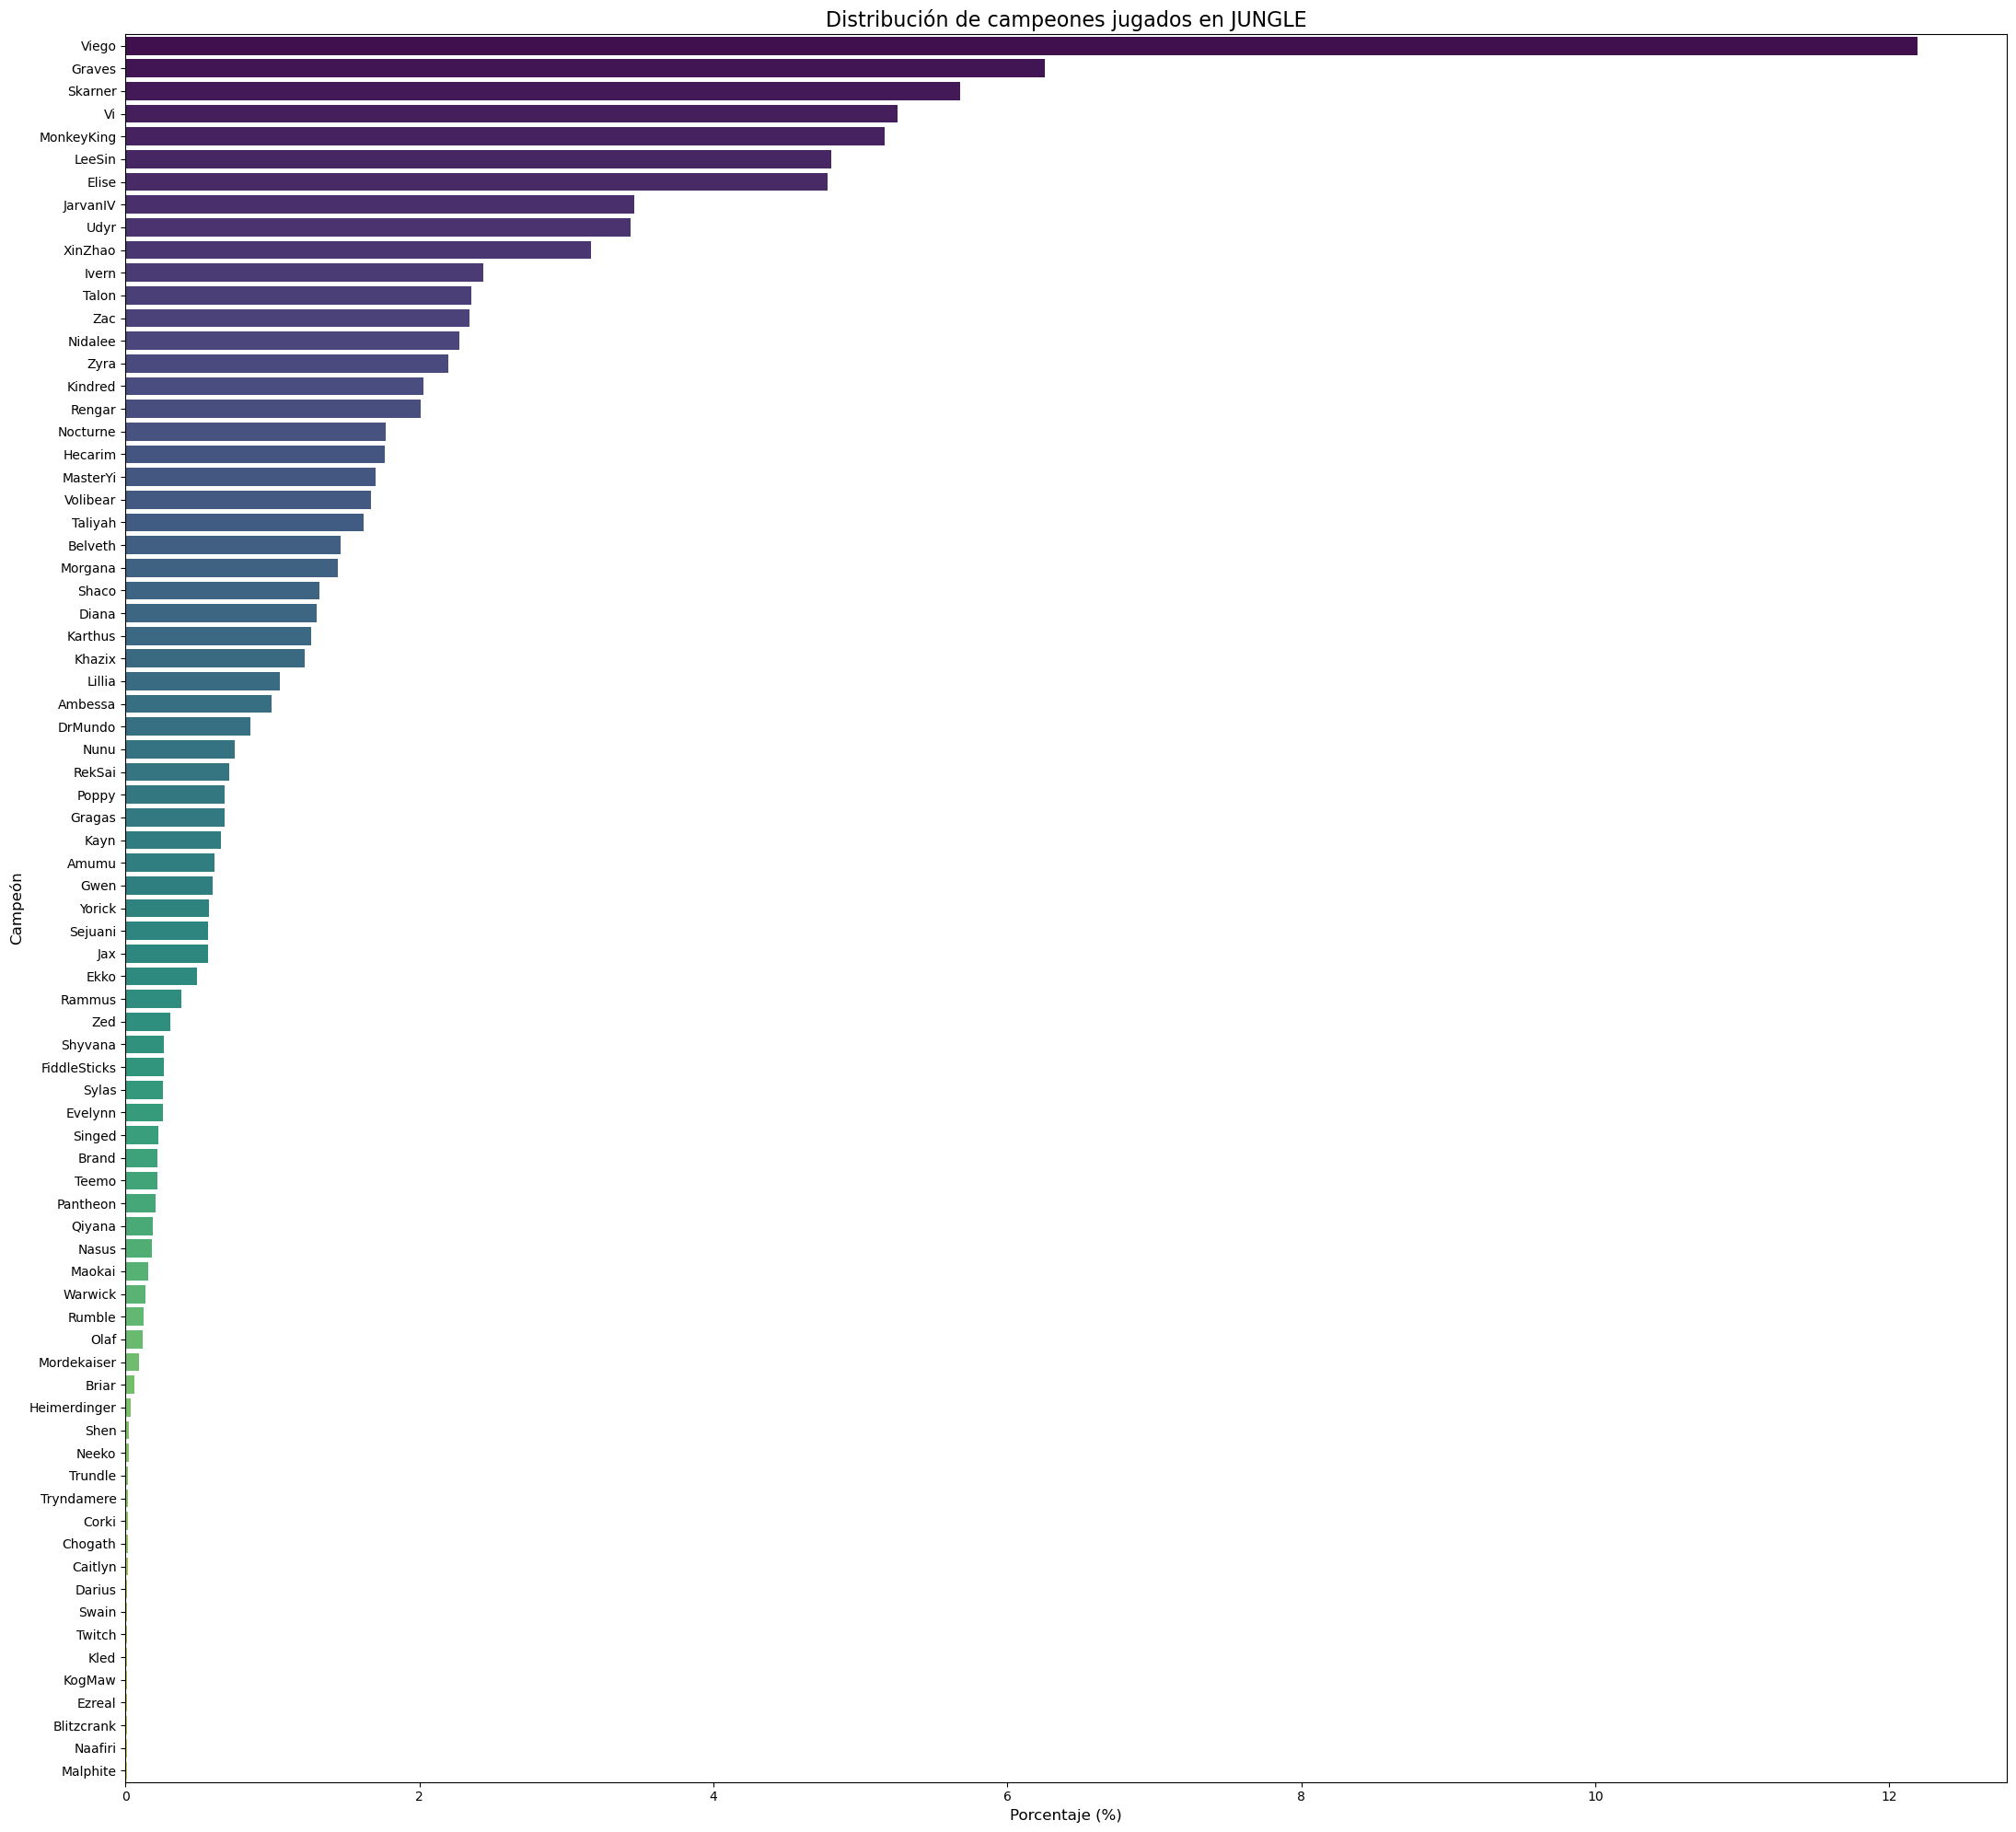

C:\Users\chris\AppData\Local\Temp\ipykernel_24088\1273003964.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='proportion', y='champion_name', data=data, palette='viridis')


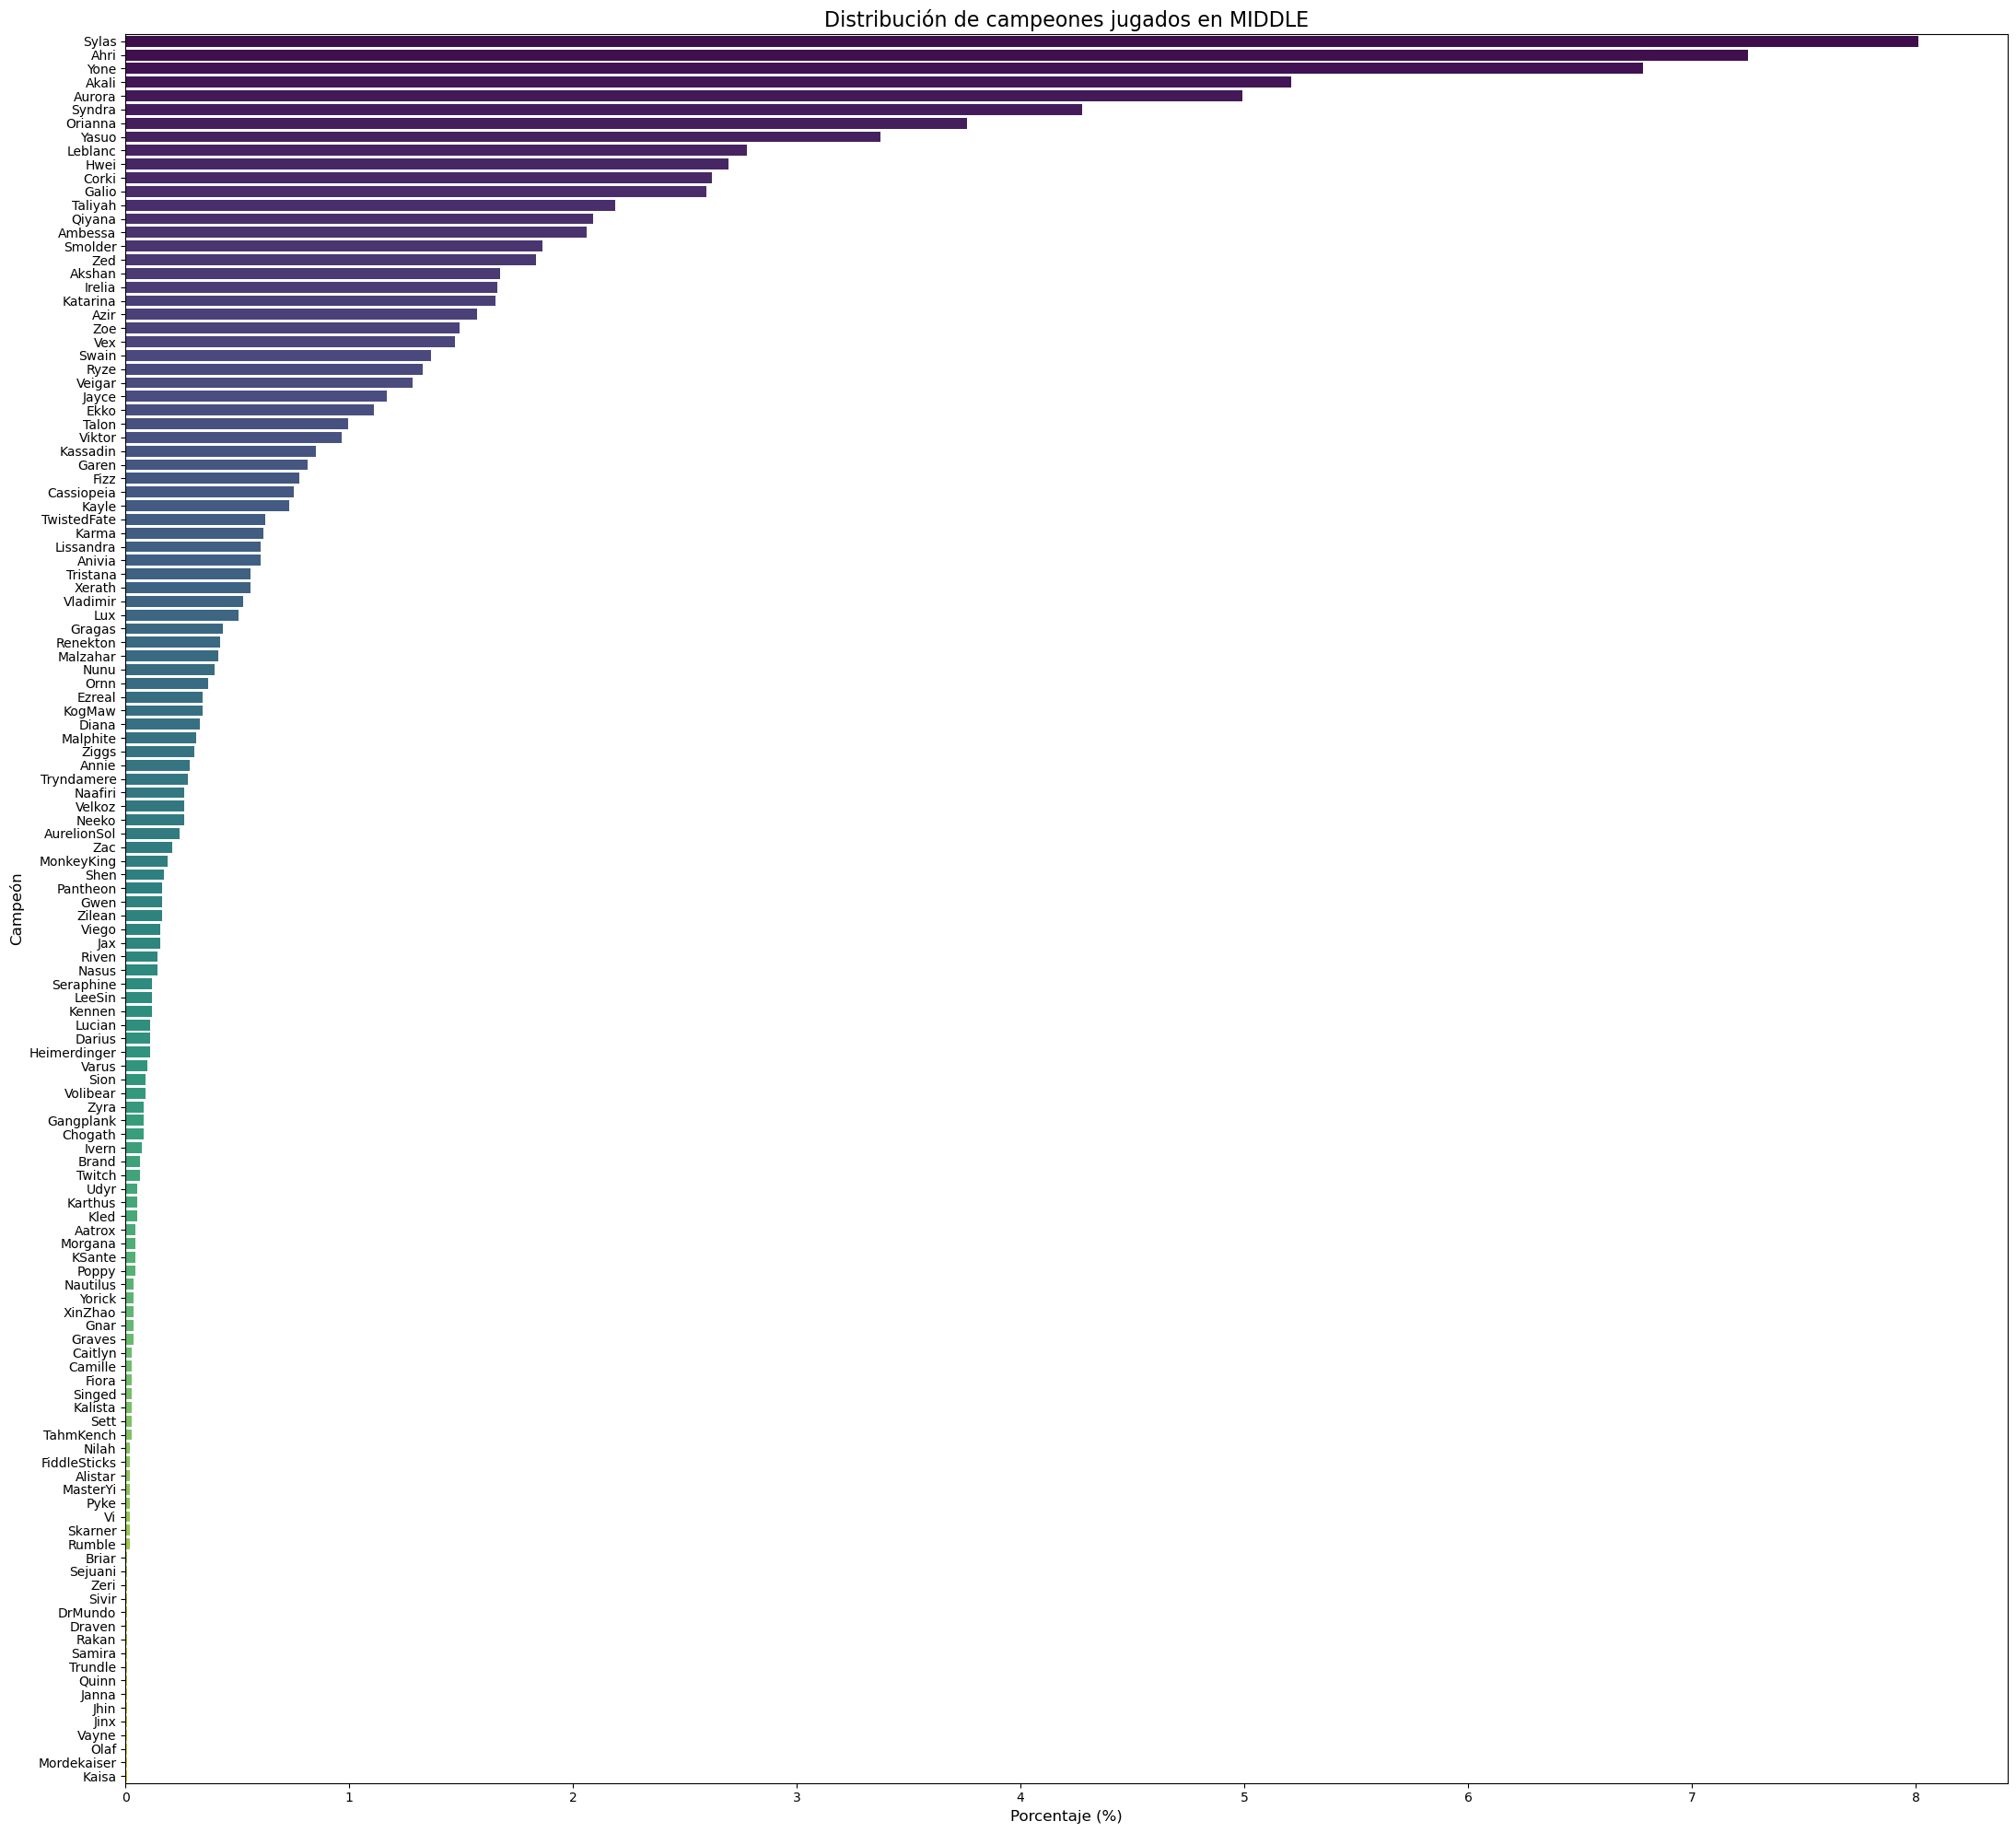

C:\Users\chris\AppData\Local\Temp\ipykernel_24088\1273003964.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='proportion', y='champion_name', data=data, palette='viridis')


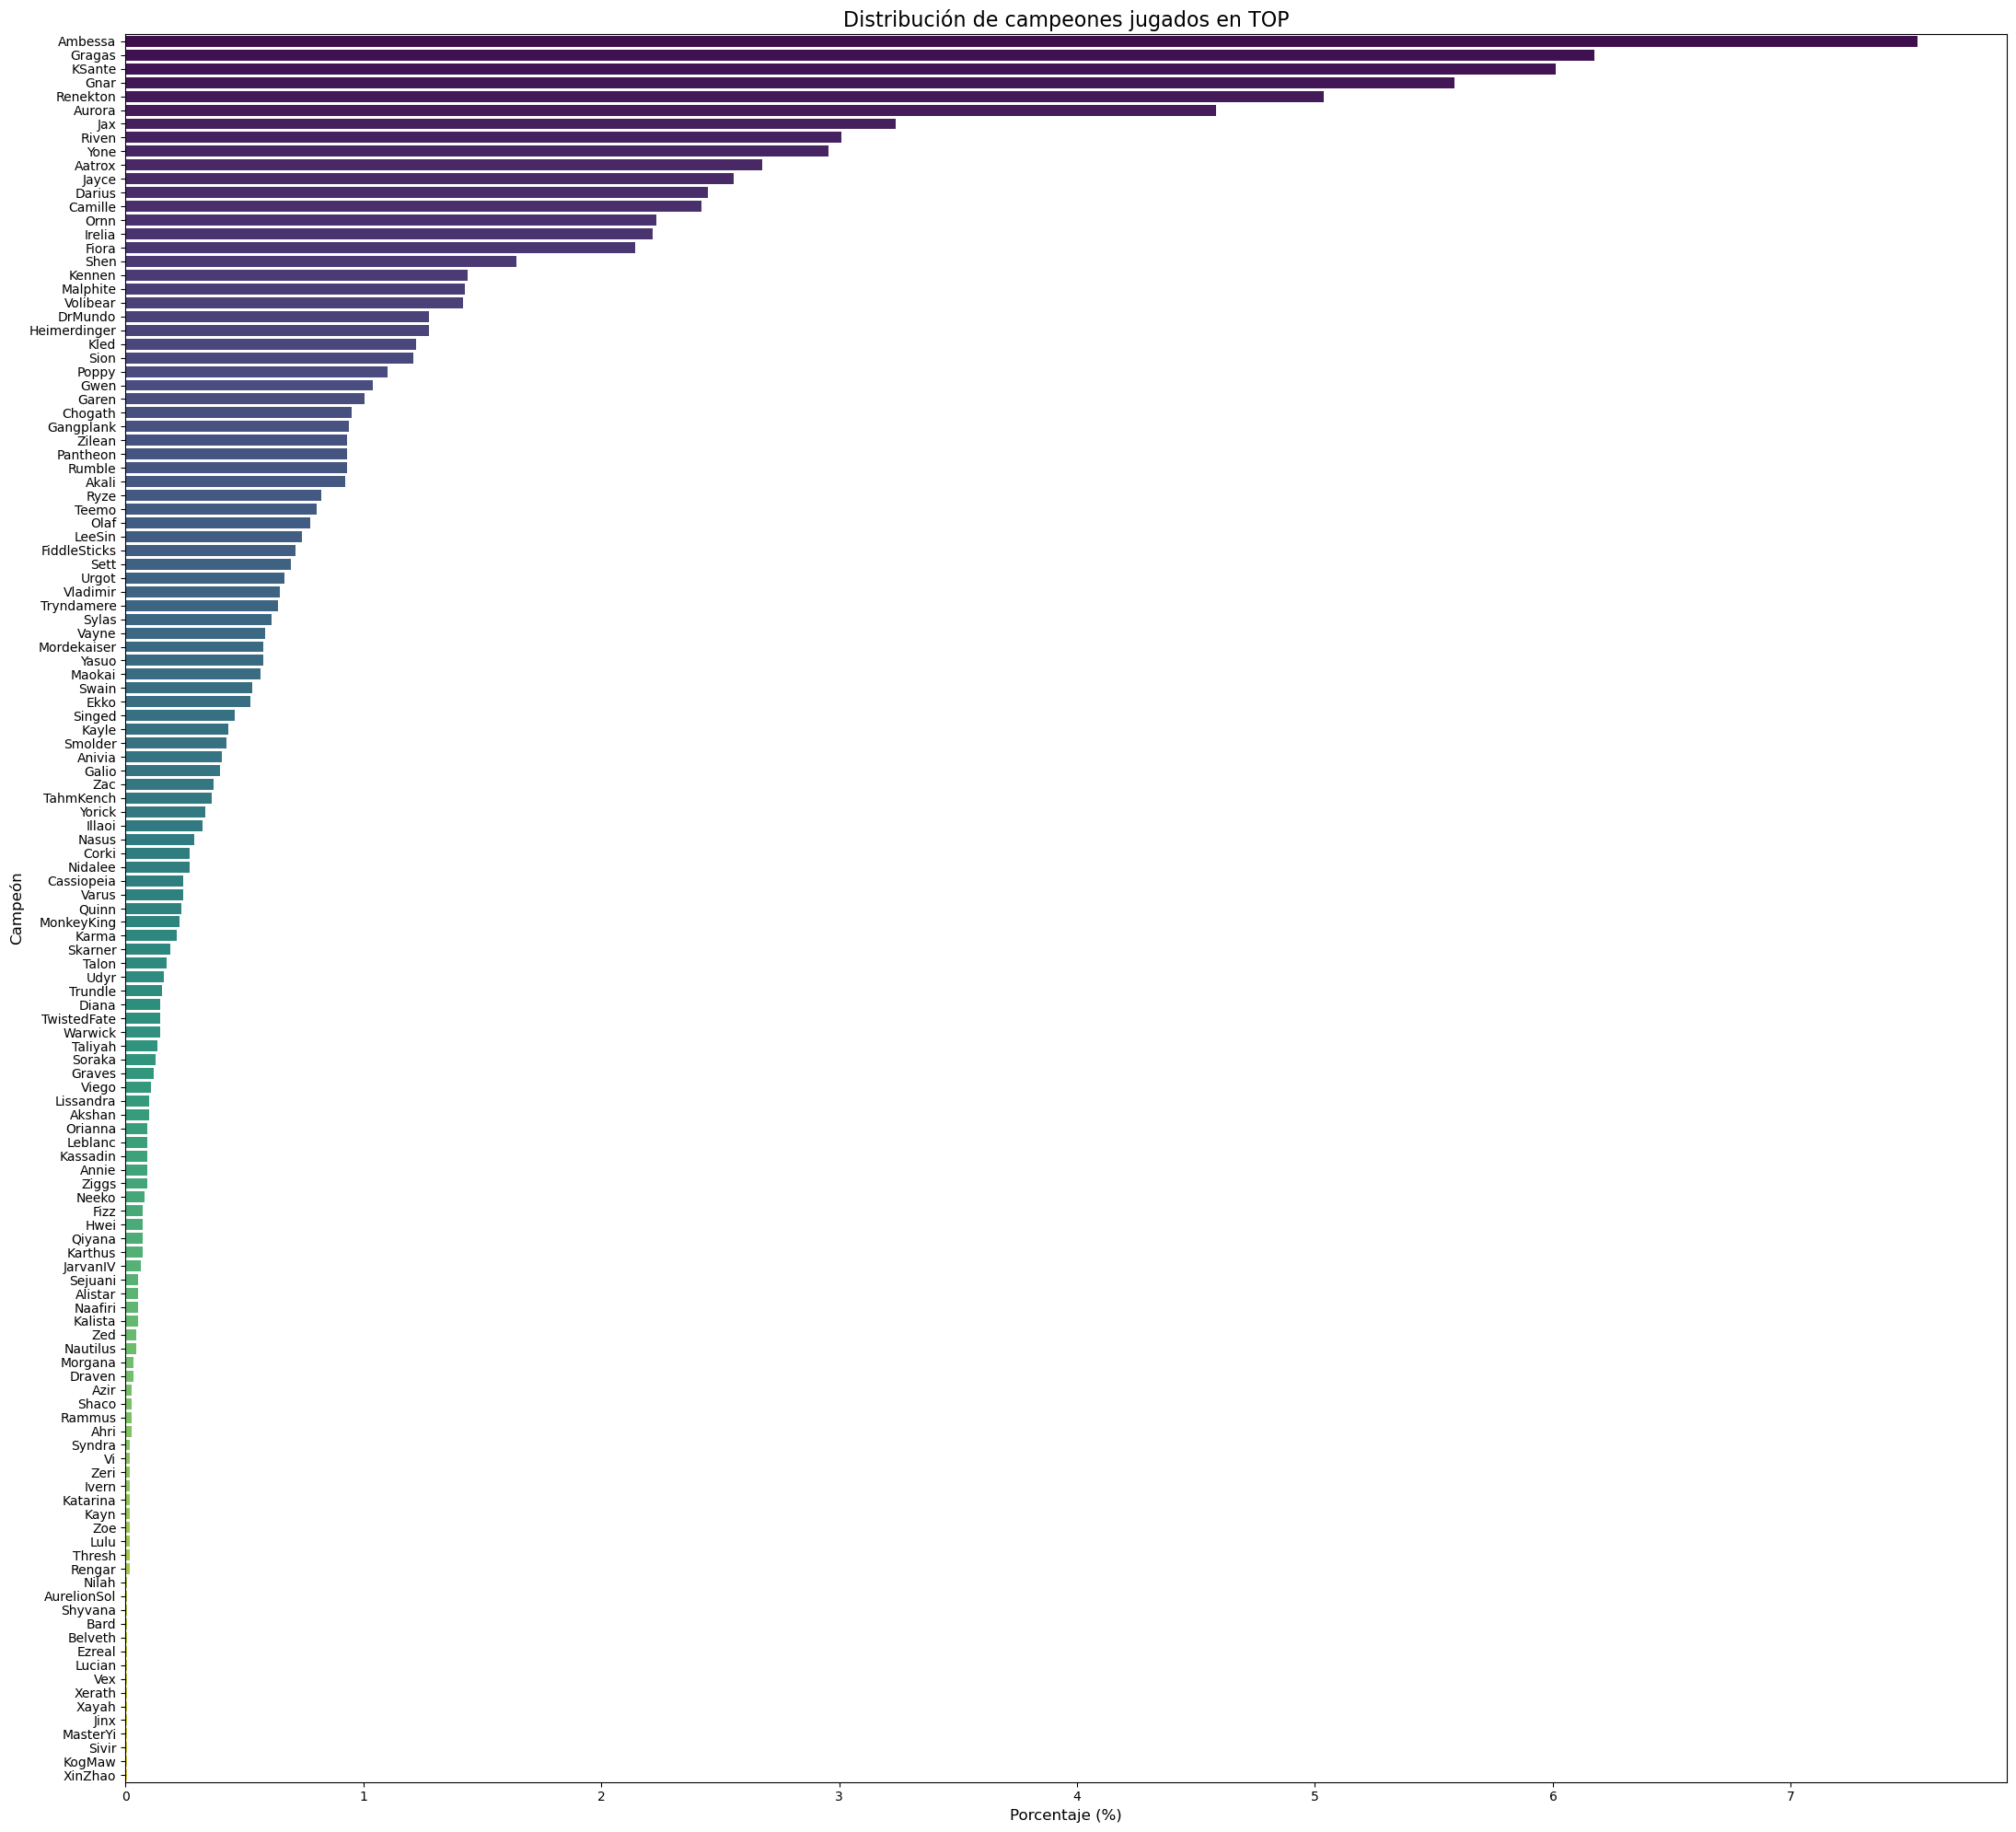

C:\Users\chris\AppData\Local\Temp\ipykernel_24088\1273003964.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='proportion', y='champion_name', data=data, palette='viridis')


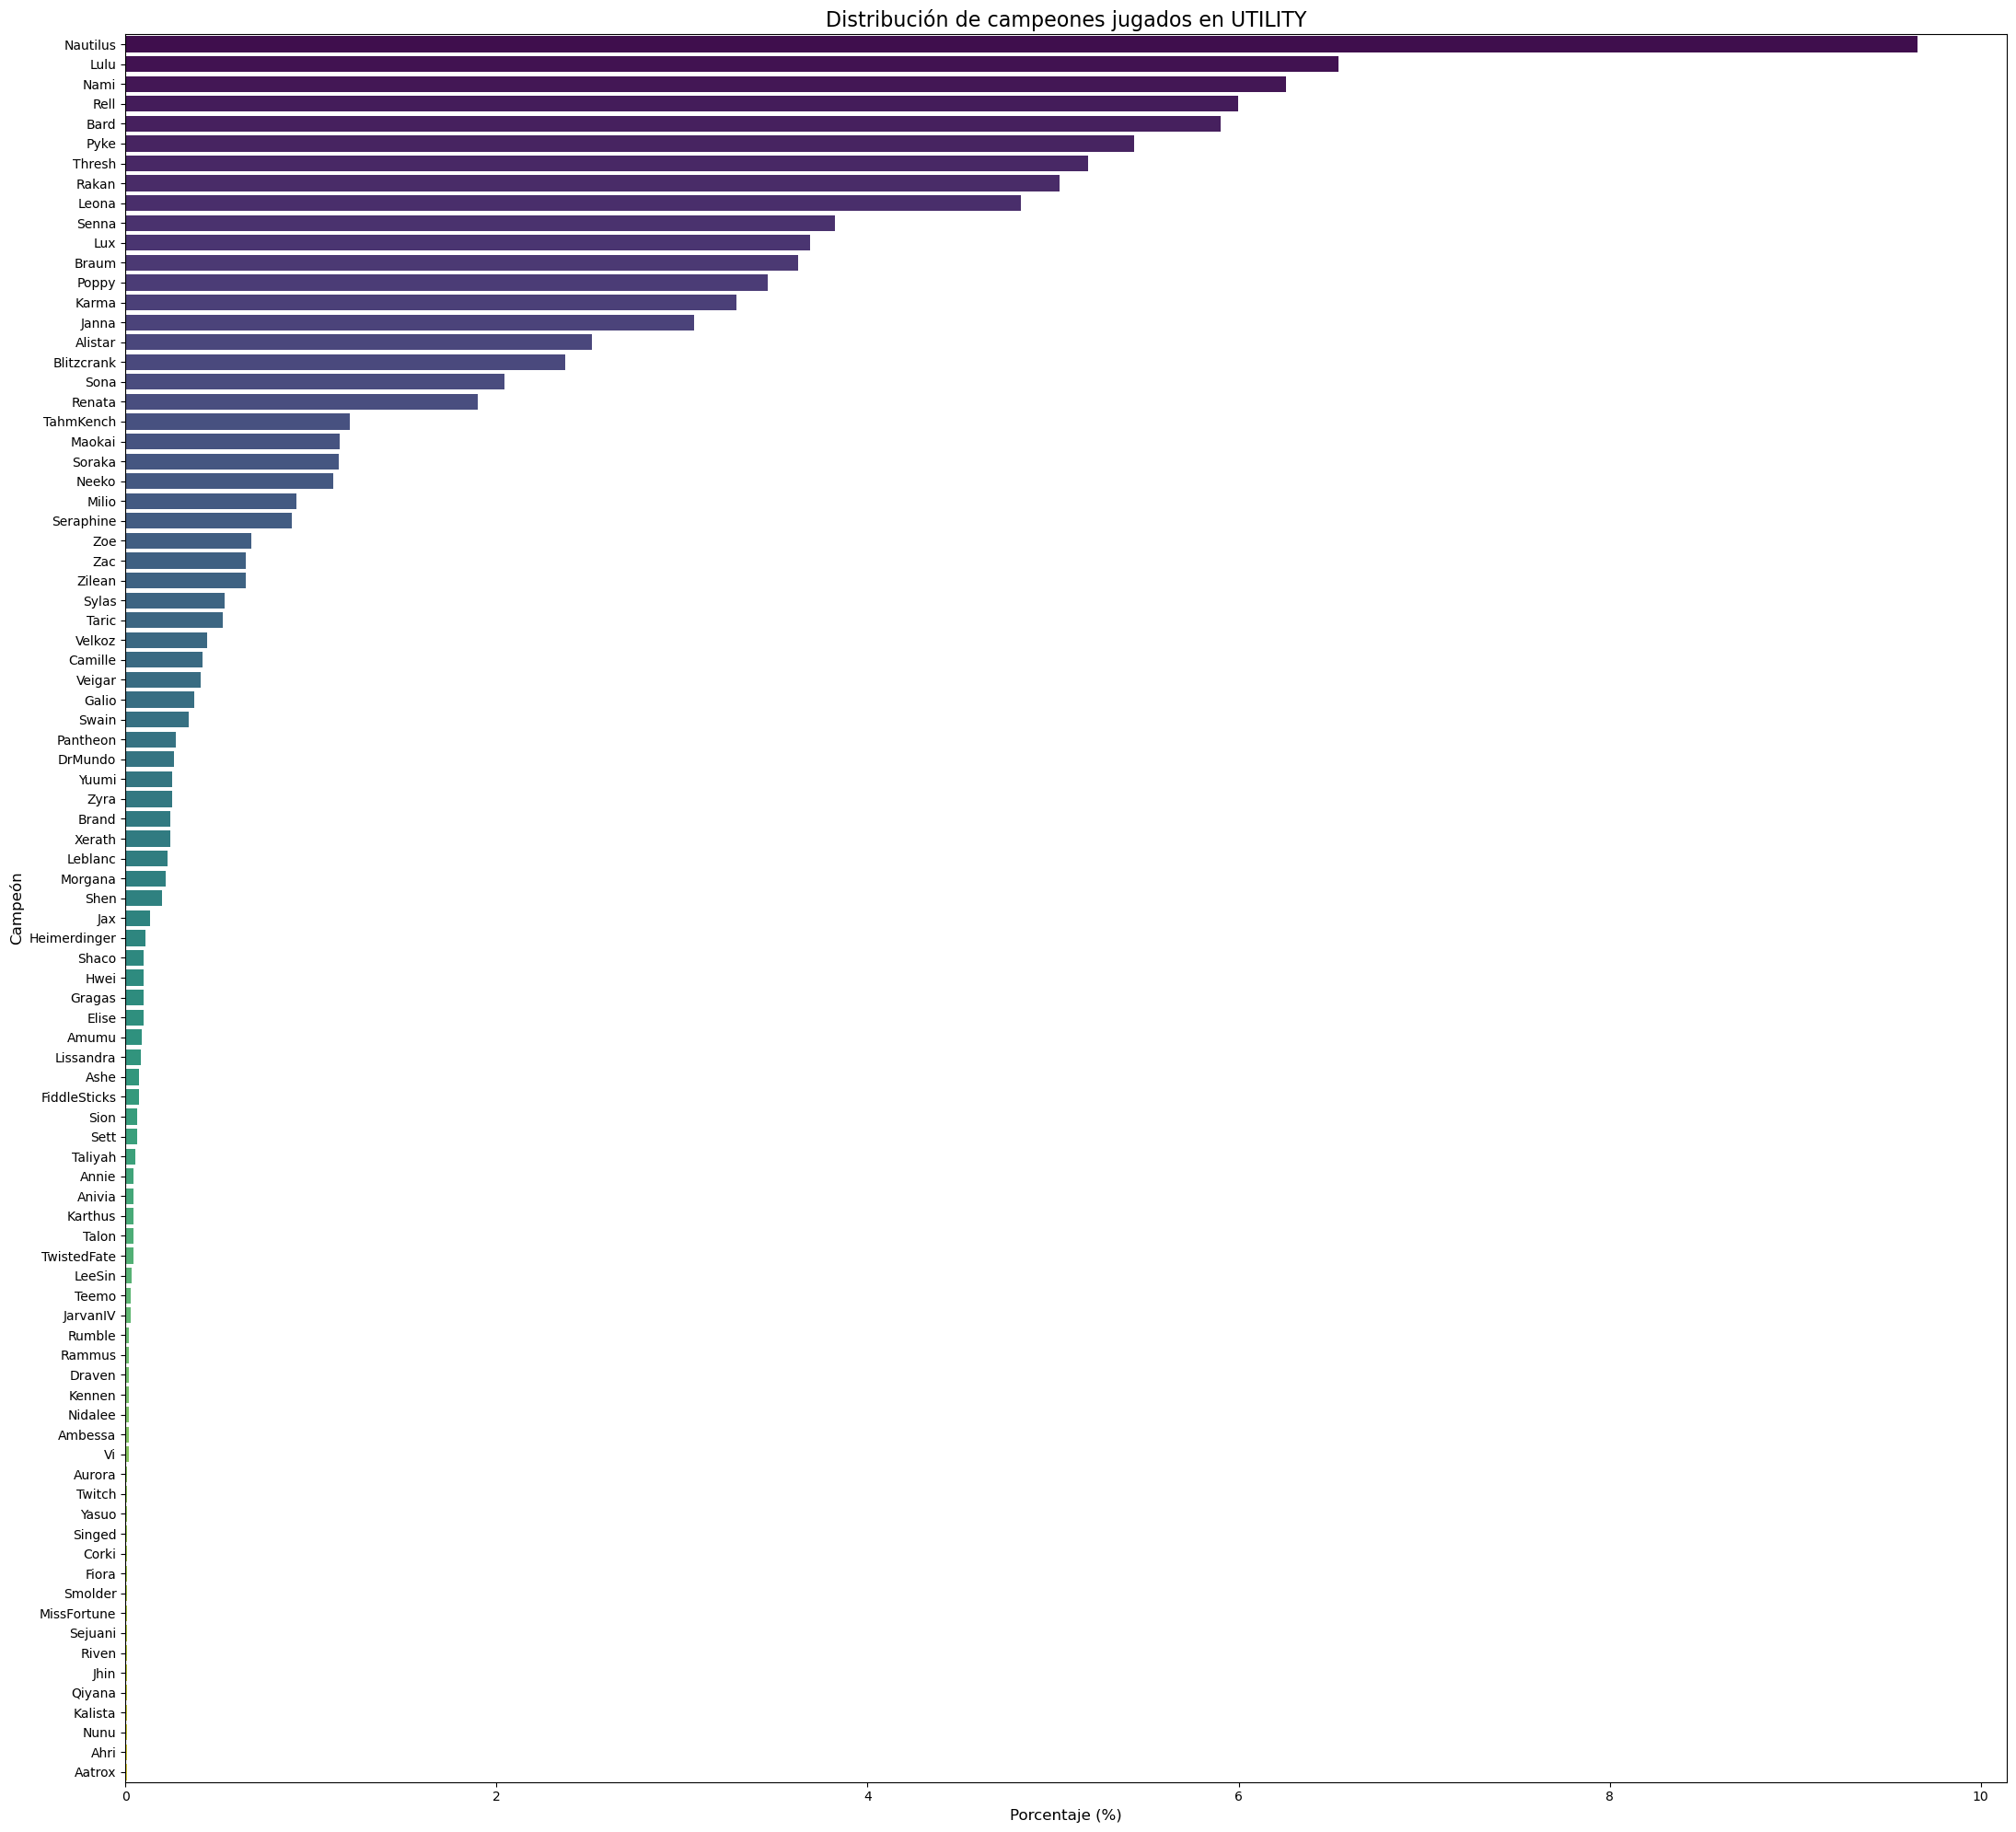

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns

# Agrupar por rol y campeón, contando las apariciones
role_champion_counts = df_ultimo_parche.groupby(['team_position', 'champion_name']).size().reset_index(name='count')

# Calcular proporciones por rol
role_champion_counts['proportion'] = role_champion_counts.groupby('team_position')['count'].transform(lambda x: x / x.sum() * 100)

# Roles únicos en el dataset
roles = role_champion_counts['team_position'].unique()

# Crear un gráfico para cada rol
for role in roles:
    plt.figure(figsize=(22, 20))
    data = role_champion_counts[role_champion_counts['team_position'] == role]
    data = data.sort_values('proportion', ascending=False)
    
    sns.barplot(x='proportion', y='champion_name', data=data, palette='viridis')
    
    plt.title(f'Distribución de campeones jugados en {role}', fontsize=16)
    plt.xlabel('Porcentaje (%)', fontsize=12)
    plt.ylabel('Campeón', fontsize=12)
    plt.tight_layout()
    plt.show()


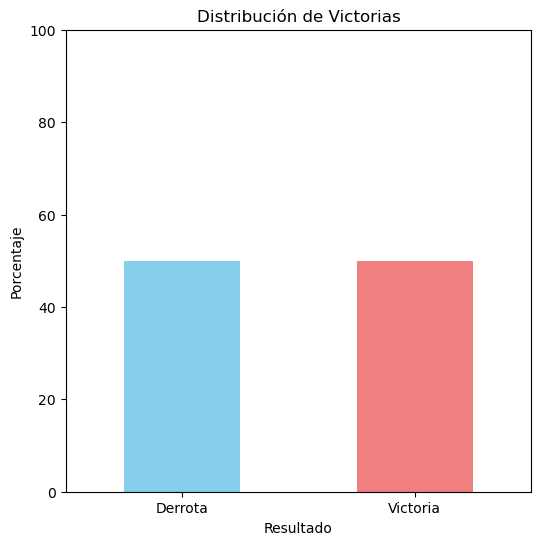

In [162]:
import matplotlib.pyplot as plt

# Calcular la distribución
win_counts = df_ultimo_parche['win'].value_counts(normalize=True) * 100  # Porcentajes

# Graficar la distribución
plt.figure(figsize=(6, 6))
win_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Distribución de Victorias')
plt.xlabel('Resultado')
plt.ylabel('Porcentaje')
plt.xticks([0, 1], ['Derrota', 'Victoria'], rotation=0)
plt.ylim(0, 100)
plt.show()


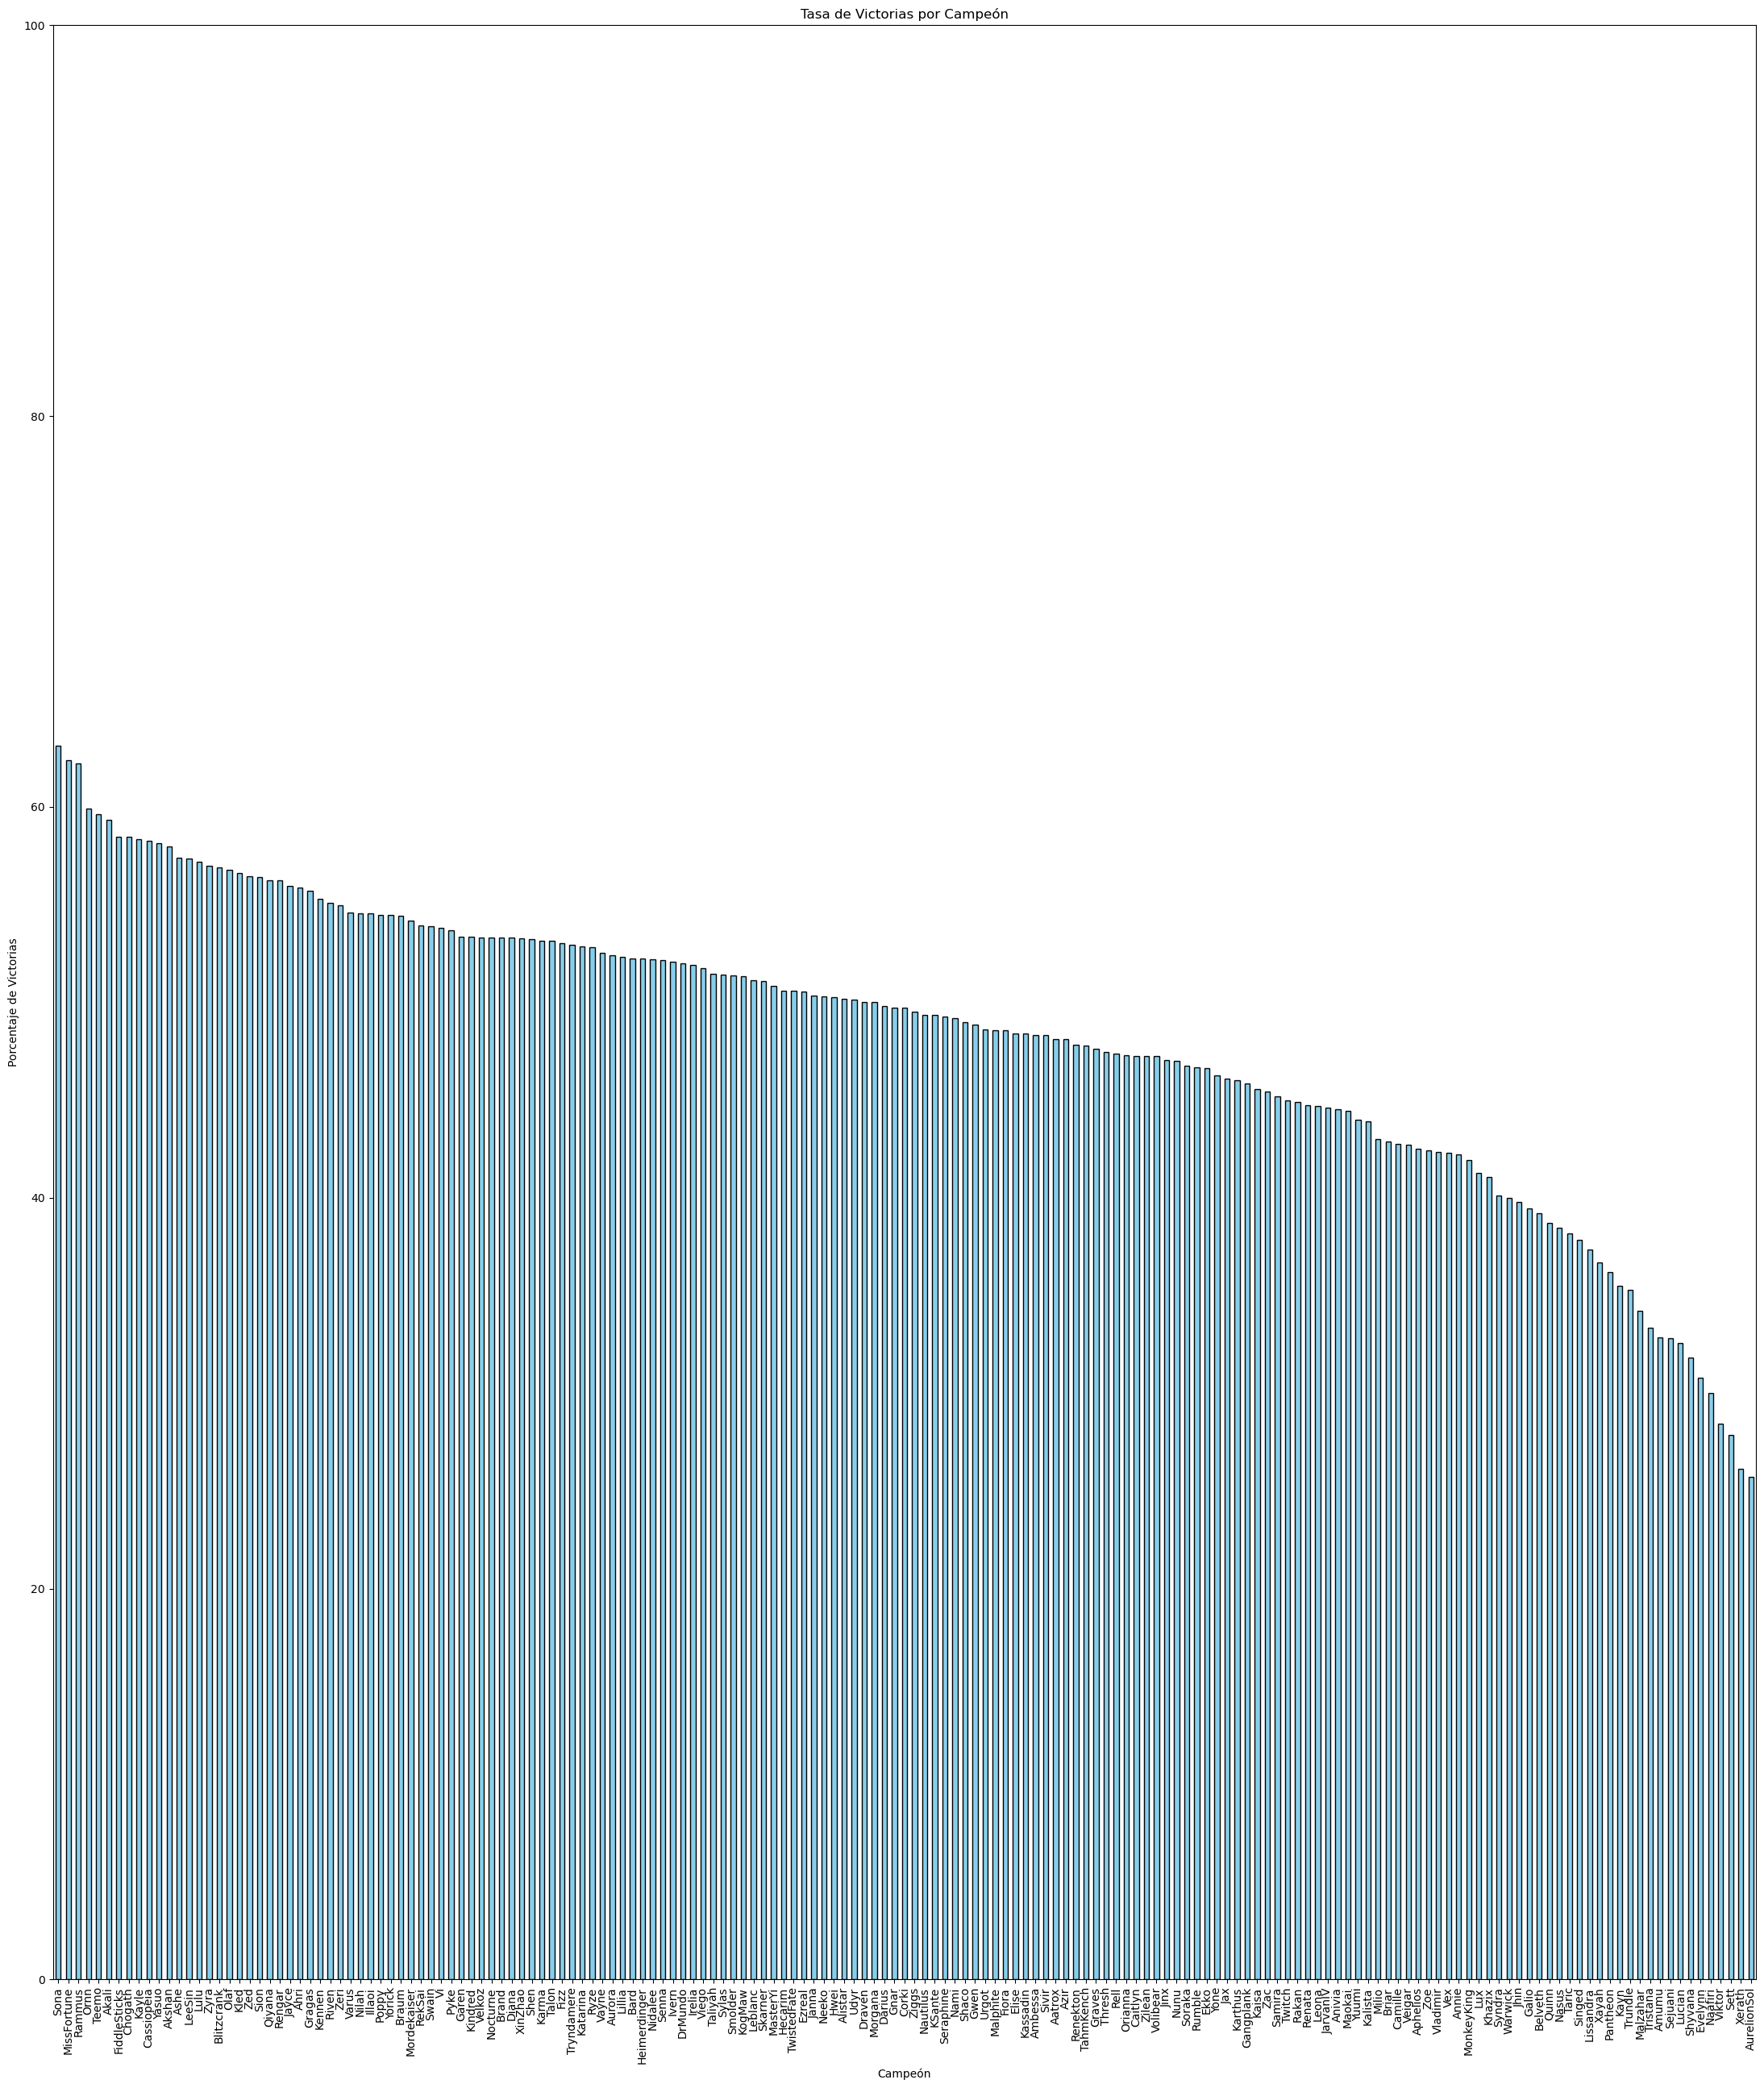

In [172]:
import matplotlib.pyplot as plt

# Agrupar por campeón y calcular el porcentaje de victorias
champion_win_rate = df_ultimo_parche.groupby('champion_name')['win'].mean() * 100  # Promedio de victorias por campeón (en %)
champion_win_rate = champion_win_rate.sort_values(ascending=False)  # Ordenar por tasa de victorias

# Graficar
plt.figure(figsize=(22, 26))
champion_win_rate.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Tasa de Victorias por Campeón')
plt.xlabel('Campeón')
plt.ylabel('Porcentaje de Victorias')
plt.xticks(rotation=90)  # Rotar los nombres de los campeones
plt.ylim(0, 100)  # Escalar entre 0 y 100%
plt.tight_layout()
plt.show()


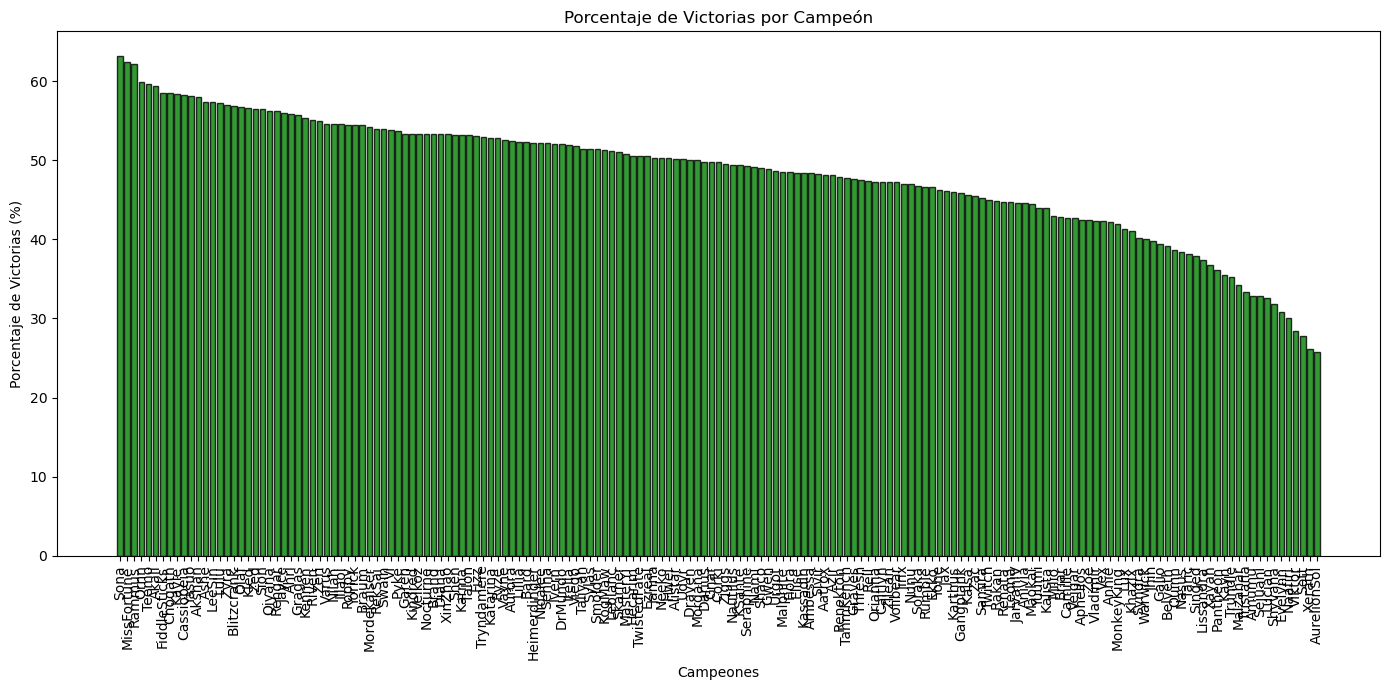

In [170]:
import matplotlib.pyplot as plt
import pandas as pd

# Agrupar por campeón y calcular métricas
champion_stats = df_ultimo_parche.groupby('champion_name').agg(
    total_games=('win', 'count'),     # Total de partidas jugadas por campeón
    total_wins=('win', 'sum')        # Total de victorias por campeón
)
# Calcular porcentaje de victorias
champion_stats['win_rate'] = (champion_stats['total_wins'] / champion_stats['total_games']) * 100

# Ordenar por porcentaje de victorias
champion_stats = champion_stats.sort_values('win_rate', ascending=False)

# Configuración del gráfico
plt.figure(figsize=(14, 7))
x = range(len(champion_stats))

# Graficar porcentaje de victorias
plt.bar(x, champion_stats['win_rate'], color='green', alpha=0.8, edgecolor='black')

# Configuración de ejes
plt.xticks(x, champion_stats.index, rotation=90)  # Nombres de campeones en el eje x
plt.xlabel('Campeones')
plt.ylabel('Porcentaje de Victorias (%)')
plt.title('Porcentaje de Victorias por Campeón')
plt.tight_layout()
plt.show()



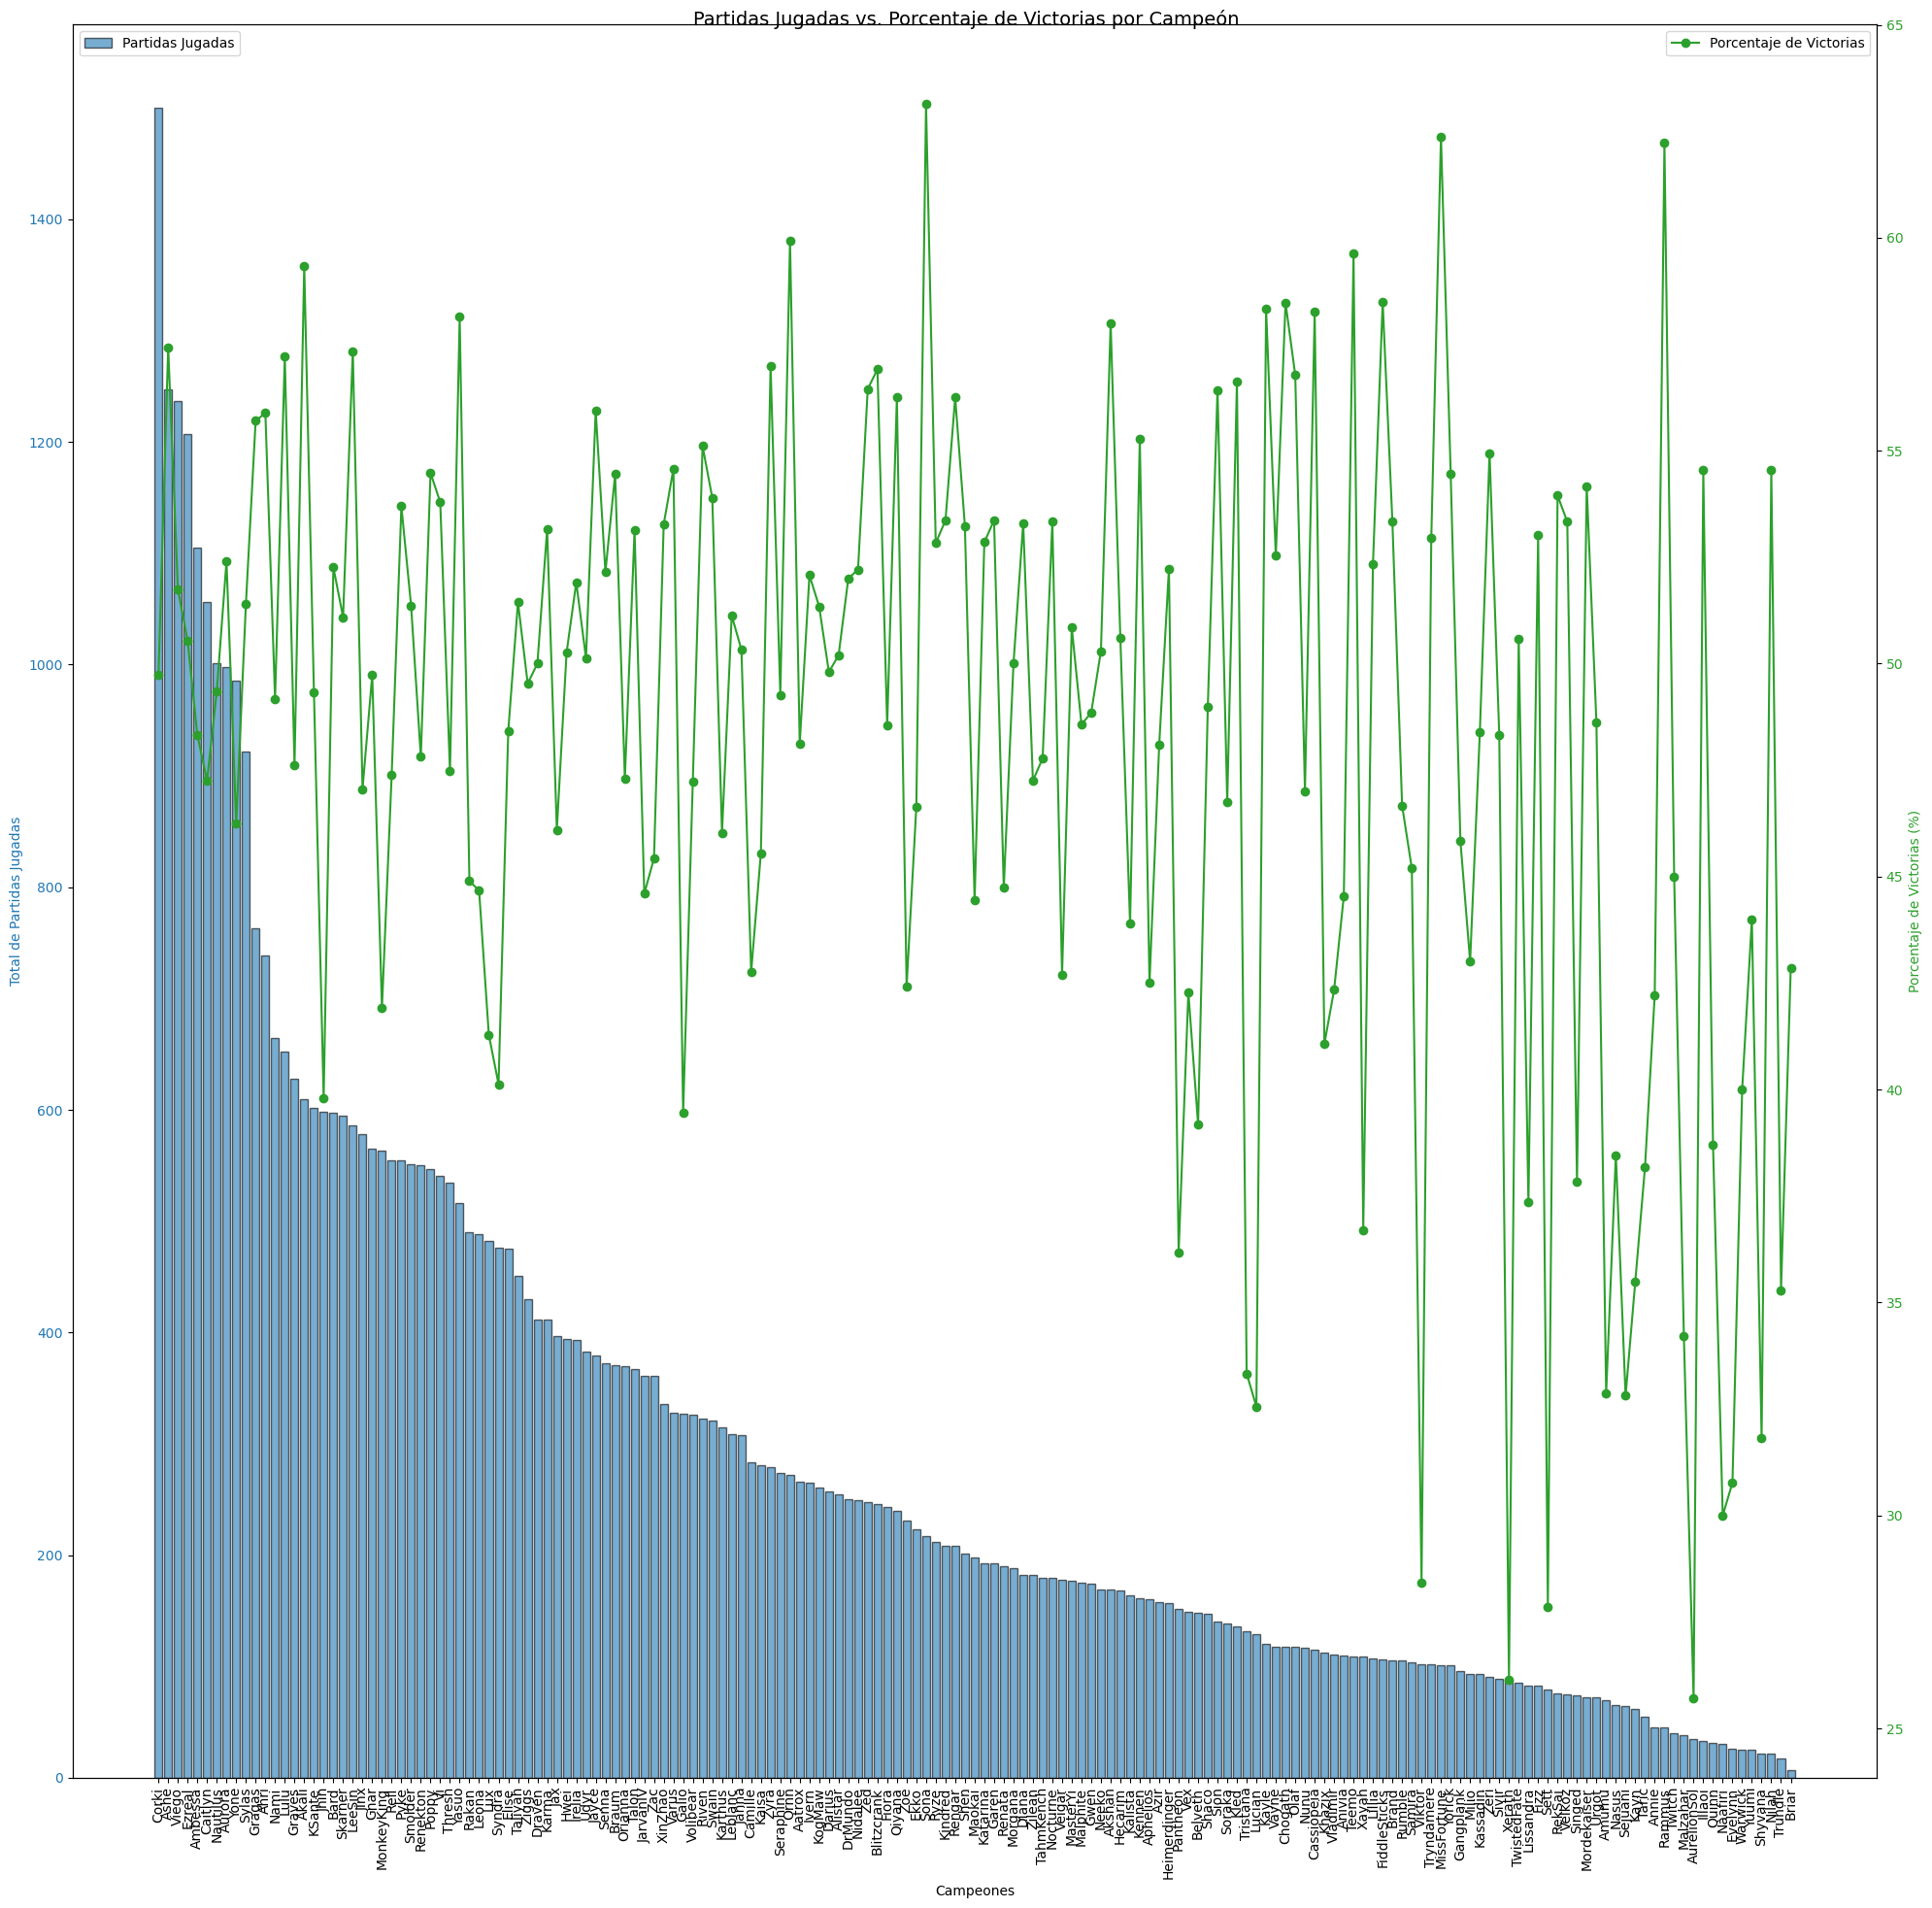

In [176]:
import matplotlib.pyplot as plt

# Agrupar por campeón y calcular métricas
champion_stats = df_ultimo_parche.groupby('champion_name').agg(
    total_games=('win', 'count'),     # Total de partidas jugadas por campeón
    total_wins=('win', 'sum')        # Total de victorias por campeón
)
# Calcular porcentaje de victorias
champion_stats['win_rate'] = (champion_stats['total_wins'] / champion_stats['total_games']) * 100

# Ordenar por número de partidas jugadas
champion_stats = champion_stats.sort_values('total_games', ascending=False)

# Crear figura
fig, ax1 = plt.subplots(figsize=(20, 20))

# Eje y para el número de partidas
color = 'tab:blue'
ax1.set_xlabel('Campeones')
ax1.set_ylabel('Total de Partidas Jugadas', color=color)
bars = ax1.bar(champion_stats.index, champion_stats['total_games'], color=color, alpha=0.6, edgecolor='black', label='Partidas Jugadas')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(range(len(champion_stats)))
ax1.set_xticklabels(champion_stats.index, rotation=90)

# Eje y para el porcentaje de victorias
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Porcentaje de Victorias (%)', color=color)
line, = ax2.plot(champion_stats.index, champion_stats['win_rate'], color=color, marker='o', label='Porcentaje de Victorias')
ax2.tick_params(axis='y', labelcolor=color)

# Títulos y leyendas
fig.suptitle('Partidas Jugadas vs. Porcentaje de Victorias por Campeón', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Ajuste de diseño
fig.tight_layout()
plt.show()



KDA
=
Kills
+
Asistencias
/
Muertes

​

In [158]:
# Ordenar por una columna en orden ascendente
df_sorted = df_ultimo_parche.sort_values(by='total_time_cc_dealt', ascending=True)
df_sorted[['champion_name','total_time_cc_dealt']].tail(10)

,champion_name,total_time_cc_dealt
47580,KSante,3044
48950,KSante,3044
26121,Udyr,3135
57811,Udyr,3135
2015,KSante,3258
47335,KSante,3258
57630,KSante,3296
32240,KSante,3398
25940,KSante,3398
53730,KSante,3805


C:\Users\chris\AppData\Local\Temp\ipykernel_24088\1577945767.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=role_counts.index, y=role_counts.values, palette='Set2')


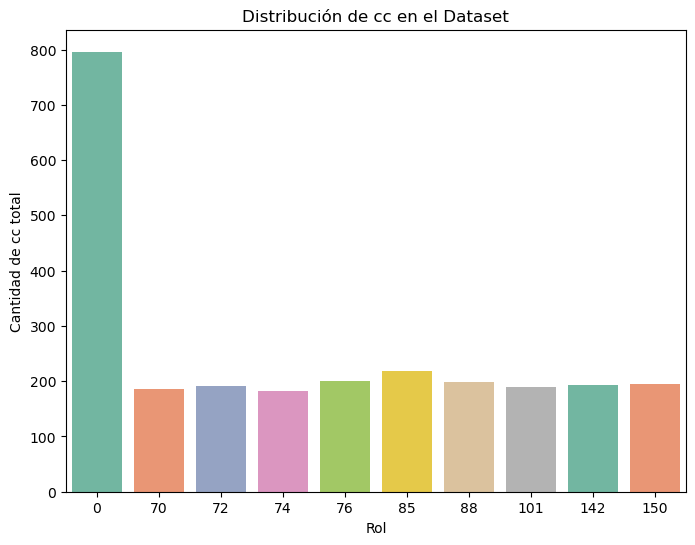

In [140]:
# Distribución de roles 
role_counts = df_ultimo_parche['total_time_cc_dealt'].value_counts().head(10)

# Graficar la distribución de roles
plt.figure(figsize=(8, 6))
sns.barplot(x=role_counts.index, y=role_counts.values, palette='Set2')
plt.xlabel('Rol')
plt.ylabel('Cantidad de cc total')
plt.title('Distribución de cc en el Dataset')
plt.show()

In [74]:
# Ejemplo de análisis de KDA
df_ultimo_parche['kda'] = (df_ultimo_parche['kills'] + df_ultimo_parche['assists']) / df_ultimo_parche['deaths']
df_ultimo_parche['kda'] = df_ultimo_parche['kda'].replace([float('inf'), float('-inf')], 'perfecto')
#df_kda_champs = df_ultimo_parche.groupby('champion_name')['kda'].mean().sort_values(ascending=False)

df_ultimo_parche.head(60)

C:\Users\chris\AppData\Local\Temp\ipykernel_24088\2751948136.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['kda'] = (df_ultimo_parche['kills'] + df_ultimo_parche['assists']) / df_ultimo_parche['deaths']
C:\Users\chris\AppData\Local\Temp\ipykernel_24088\2751948136.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ultimo_parche['kda'] = df_ultimo_parche['kda'].replace([float('inf'), float('-inf')], 'perfecto')


,match_id,data_version,participants,game_creation,game_duration,game_end_timestamp,game_start_timestamp,game_mode,game_name,game_type,...,physical_damage_dealt,physical_damage_dealt_to_champions,physical_damage_taken,true_damage_dealt,true_damage_dealt_to_champions,true_damage_taken,time_spent_dead,total_time_cc_dealt,vision_wards_bought_in_game,kda
0,EUW1_7210922343,2,['MmEwQUECKGab-xQkpr7qLaz0ynnFxiFuy6ecsWZ1bMiJ...,1733087598057,1997,1733089637632,1733087639902,CLASSIC,teambuilder-match-7210922343,MATCHED_GAME,...,14921,2245,11331,3554,2256,611,102,272,0,5.0
1,EUW1_7210922343,2,['MmEwQUECKGab-xQkpr7qLaz0ynnFxiFuy6ecsWZ1bMiJ...,1733087598057,1997,1733089637632,1733087639902,CLASSIC,teambuilder-match-7210922343,MATCHED_GAME,...,24590,2074,22571,91023,3617,1362,70,312,5,5.0
2,EUW1_7210922343,2,['MmEwQUECKGab-xQkpr7qLaz0ynnFxiFuy6ecsWZ1bMiJ...,1733087598057,1997,1733089637632,1733087639902,CLASSIC,teambuilder-match-7210922343,MATCHED_GAME,...,212222,32362,5801,15343,6084,655,68,205,2,9.5
3,EUW1_7210922343,2,['MmEwQUECKGab-xQkpr7qLaz0ynnFxiFuy6ecsWZ1bMiJ...,1733087598057,1997,1733089637632,1733087639902,CLASSIC,teambuilder-match-7210922343,MATCHED_GAME,...,151956,19405,7017,38447,0,386,94,714,2,4.333333
4,EUW1_7210922343,2,['MmEwQUECKGab-xQkpr7qLaz0ynnFxiFuy6ecsWZ1bMiJ...,1733087598057,1997,1733089637632,1733087639902,CLASSIC,teambuilder-match-7210922343,MATCHED_GAME,...,3087,951,8438,5658,870,194,84,63,8,4.0
5,EUW1_7210922343,2,['MmEwQUECKGab-xQkpr7qLaz0ynnFxiFuy6ecsWZ1bMiJ...,1733087598057,1997,1733089637632,1733087639902,CLASSIC,teambuilder-match-7210922343,MATCHED_GAME,...,101932,5294,13221,30131,1605,2587,108,227,0,1.0
6,EUW1_7210922343,2,['MmEwQUECKGab-xQkpr7qLaz0ynnFxiFuy6ecsWZ1bMiJ...,1733087598057,1997,1733089637632,1733087639902,CLASSIC,teambuilder-match-7210922343,MATCHED_GAME,...,204872,13545,29297,71182,618,2135,132,229,16,2.4
7,EUW1_7210922343,2,['MmEwQUECKGab-xQkpr7qLaz0ynnFxiFuy6ecsWZ1bMiJ...,1733087598057,1997,1733089637632,1733087639902,CLASSIC,teambuilder-match-7210922343,MATCHED_GAME,...,7105,343,19170,9710,225,5095,57,125,3,2.25
8,EUW1_7210922343,2,['MmEwQUECKGab-xQkpr7qLaz0ynnFxiFuy6ecsWZ1bMiJ...,1733087598057,1997,1733089637632,1733087639902,CLASSIC,teambuilder-match-7210922343,MATCHED_GAME,...,15045,742,10253,8915,63,340,114,360,5,1.0
9,EUW1_7210922343,2,['MmEwQUECKGab-xQkpr7qLaz0ynnFxiFuy6ecsWZ1bMiJ...,1733087598057,1997,1733089637632,1733087639902,CLASSIC,teambuilder-match-7210922343,MATCHED_GAME,...,2344,514,12704,3023,698,2669,157,57,13,1.6
